# <center> Guia 5 </center>
Alumnes: Borrell Trinidad, Brusco Agustín

Docentes: Rodriguez Imazio Paola, Amette Estrada Julian

## Imports Generales
Ejecutar la siguiente celda para poder correr el código del Notebook.

In [1]:
import sys
import os
# Colab Set-Up
if ("google.colab" in sys.modules) and (os.getcwd() == '/content'):
    print(
        "Ejecutando en Google Colab\n"
        "Para correr el notebook se necesita clonar un repositorio con funciones "
        "auxiliares e instalar librerías."
    )
    if input(
        "¿Desea clonar el repositorio e instalar los paquetes necesarios?"
        "[y/n]:"
    ).lower() == "y":
        os.system("git clone https://github.com/agustinbrusco/Sistemas_Complejos.git")
        print(
            "Se clonó https://github.com/agustinbrusco/Sistemas_Complejos.git."
        )
        os.chdir("Sistemas_Complejos/guias/")
        %pip install findiff
        %pip install ipympl
    from google.colab import output
    output.enable_custom_widget_manager()

# Imports Generales
from typing import Callable
import numpy as np
from numba import njit, prange
from numpy.typing import ArrayLike
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib import animation

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

def gaussian(x, mu, sig):
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )

# **Ejercicio 1: Modelo de presa predador Lotka-Volterra**

---



El modelo de Lotka-Volterra describe la dinámica de interacción de dos poblaciones, y esta dado por

$$ u_t =   au - buv + D_1 u_{xx}, $$
$$ v_t = - cv + duv + D_2 v_{xx}. $$

En estas ecuaciones $u(x,t)$ es la densidad de presas, $v(x,t)$ la de predadores, $a$ la tasa de nacimiento de presas, $c$ la tasa de muerte de predadores, $b$ y $d$ son los acoplamientos entre especies, y $D_1$ y $D_2$ sus difusividades.


**a**) Resolvé numéricamente el sistema considerando condiciones de contorno periódicas en el dominio unidimensional $x \in [0,2\pi)$, utilizando un método a elección. Elegí todos los parámetros y definí las condiciones iniciales para $u$ y para $v$. Explicá detalladamente la elección del método, de los parámetros y de las condiciones iniciales. Describí la dinámica del sistema en término de las soluciones obtenidas.

**b**) Utilizando tu modelo numérico mostrá el efecto que tienen los coeficientes de difusión en el modelo. *Ayuda: probá distintos valores de* $D_1$ y $D_2$

### a)
A continuación estudiamos el modelo de Lotka-Volterra usando un método pseudoespectral, considerando condiciones iniciales periódicas para ambos: presas y predadores.

In [3]:
# Definimos funciones para la evolucionar la PDE
def evol_lotka_volterra(
    u: ArrayLike,
    v: ArrayLike,
    k: ArrayLike,
    D1: float,
    D2: float,
    a: float,
    b: float,
    c: float,
    d: float,
    dt: float,
):
    """Evoluciona en el tiempo la PDE usando el método pseudoespectral y \
Runge-Kutta de segundo orden.
    """
    u_hat = np.fft.rfft(u)  # Transformamos al espacio de Fourier
    u_hat_inicial = u_hat  # Guardamos el estado inicial
    v_hat = np.fft.rfft(v)
    v_hat_inicial = v_hat

    for ord in [2, 1]:  # Bucle para el Runge-Kutta
        D = dt / ord
        u_v_hat = compute_interaction(u_hat, v_hat)

        u_hat = u_hat_inicial + D * (
            a * u_hat - b * u_v_hat - D1 * (k**2) * u_hat
        )  # Integramos en el tiempo
        u_hat[(u.size // 3) :] = 0  # Dealiasing (eliminemos modos espúreos!)

        v_hat = v_hat_inicial + D * (
            -c * v_hat + d * u_v_hat - D2 * (k**2) * v_hat
        )  # Integramos en el tiempo
        v_hat[(v.size // 3) :] = 0  # Dealiasing (eliminemos modos espúreos!)

    u_nuevo = np.fft.irfft(u_hat)  # Vuelva del espacio de Fourier
    v_nuevo = np.fft.irfft(v_hat)  # Vuelva del espacio de Fourier

    return u_nuevo, v_nuevo


def compute_interaction(u_hat, v_hat):
    """Calcula u*v usando el método pseudoespectral y devuelve el resultado \
en el espacio Fourier.
    """
    u = np.fft.irfft(u_hat)
    v = np.fft.irfft(v_hat)
    u_v_hat = np.fft.rfft(u * v)
    return u_v_hat


def lotka_volterra_pseudoespectral(
    u0: Callable[[ArrayLike], ArrayLike],
    v0: Callable[[ArrayLike], ArrayLike],
    lv_params: tuple[float, float, float, float, float, float],
    tf: float = 5,
    dt: float = 5e-5,
    nx: int = 128,
) -> tuple[ArrayLike, ArrayLike, ArrayLike]:
    # Defino mis puntos en el espacio real y los modos para el espacio de Fourier
    L = 2*np.pi

    x_vals = np.linspace(0, L, nx, endpoint=False)  # Coordenada espacial en [0,2*pi)
    t_vals = np.arange(0, tf + dt/2, dt)  # Tiempo
    nt = t_vals.size
    # Números de onda ordenados como en la FFT
    k_vals = np.fft.rfftfreq(nx, d=(x_vals[1] - x_vals[0])) * 2 * np.pi

    # Grilla para plot
    u = np.empty([nx, nt])  # Array con la velocidad
    u[:, 0] = u0(x_vals)  # Condiciones iniciales

    v = np.empty([nx, nt])  # Array con la velocidad
    v[:, 0] = v0(x_vals)  # Condiciones iniciales

    # Aplico el método de Euler para la integración temporal
    for n in tqdm(range(nt - 1), desc="Pasos de Pseudo-Espectral"):
        u[:, n+1], v[:, n+1]= evol_lotka_volterra(u[:, n], v[:, n], k_vals, *lv_params, dt = dt)
    return x_vals, t_vals, u, v

En particular estudiamos la evolución del sistema a partir de condiciones inicales armónicas desfasadas en $\pi$.

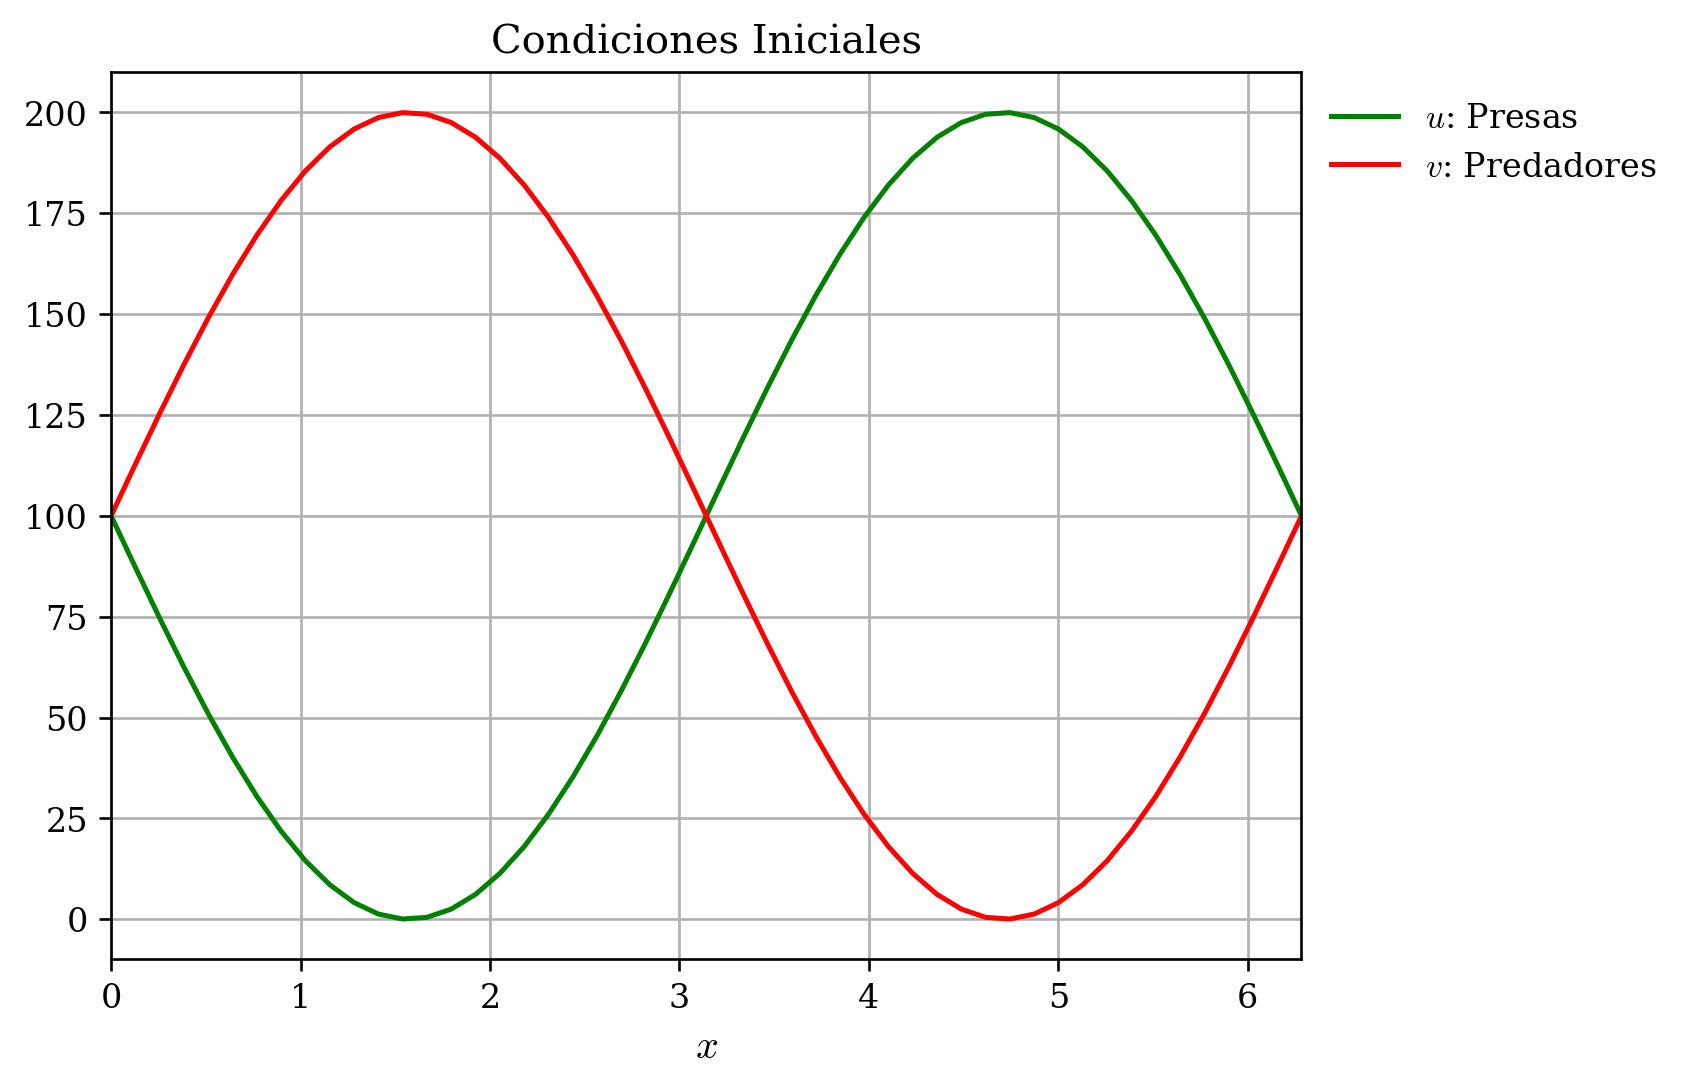

In [4]:
def u0(x):
    a = 100
    return a*np.sin(x-np.pi) + a

def v0(x):
    a = 100
    return a*np.sin(x) + a


plt.close("all")
%matplotlib inline
x_vals = np.linspace(0, 2*np.pi)
plt.title('Condiciones Iniciales')
plt.plot(x_vals, u0(x_vals), "g", label ='$u$: Presas')
plt.plot(x_vals, v0(x_vals), "r", label ='$v$: Predadores')
plt.grid()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.xlabel('$x$')
plt.xlim(x_vals[0], x_vals[-1])
plt.show()

In [34]:
# Evolucionamos el sistema por 20 segundos
x_vals, t_vals, u, v = lotka_volterra_pseudoespectral(
    u0=u0,
    v0=v0,
    lv_params=[
        0.001,  # D1: Difusión de u
        0.001,  # D2: Difusión de v
        2,  # a: Tasa de crecimiento de u
        0.02,  # b: Tasa de interacción de v sobre u
        2,  # c: Tasa de decrecimiento de v
        0.02,  # d: Tasa de interacción de u sobre v
    ],
    tf = 20,
    dt = 1e-3,
    nx = 512,
)

Pasos de Pseudo-Espectral:   0%|          | 0/20000 [00:00<?, ?it/s]

In [35]:
# Definimos funciones auxiliares para graficar ambas variables en un mismo plot
def u_v_to_rgba(u: ArrayLike, v: ArrayLike) -> ArrayLike:
    """Convierte u y v en un array RGBA para graficarlos como una imagen. El canal \
verde es u y el rojo es v. El canal alpha es el máximo de u y v de forma que el \
fondo es blanco.
    """
    # norm = np.max([np.max(u), np.max(v)])
    u_norm = u / np.max(u)  # Normalizamos u
    v_norm = v / np.max(v)  # Normalizamos v
    # Combinamos canales
    rgba = np.stack([
        v_norm**(0.5),  # R : Canal rojo
        u_norm**(0.5),  # G: Canal verde
        u_norm/2,  # B: Canal azul
        np.max(np.stack([u_norm, v_norm], axis=-1), axis=-1), # A: Canal alpha
    ], axis=-1)
    return rgba


def plot_lotka_volterra(
    x_vals: ArrayLike,
    t_vals: ArrayLike,
    u: ArrayLike,
    v: ArrayLike,
    ax: plt.Axes = None,
    add_legend: bool = True,
    add_labels: bool = True,
    **kwargs,
) -> plt.Axes:
    rgba_vals = u_v_to_rgba(u, v)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xlim(t_vals[0], t_vals[-1])
    ax.set_ylim(x_vals[0], x_vals[-1])
    if add_labels:
        ax.set_title("Evolución de Lotka-Volterra", loc="left")
        ax.set_xlabel("$t$")
        ax.set_ylabel("$x$")
        ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2 * np.pi])
        ax.set_yticklabels(["$0$", "$\pi/2$", "$\pi$", "$3\pi/2$", "$2\pi$"])
    # ax.set_aspect("auto")
    ax.imshow(
        rgba_vals,
        origin="lower",
        extent=[t_vals[0], t_vals[-1], x_vals[0], x_vals[-1]],
        **kwargs,
    )
    if add_legend:
        ax.plot([], [], "s", c="springgreen", label ='$u$: Presas')
        ax.plot([], [], "s", c="red", label ='$v$: Predadores')
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
    return ax

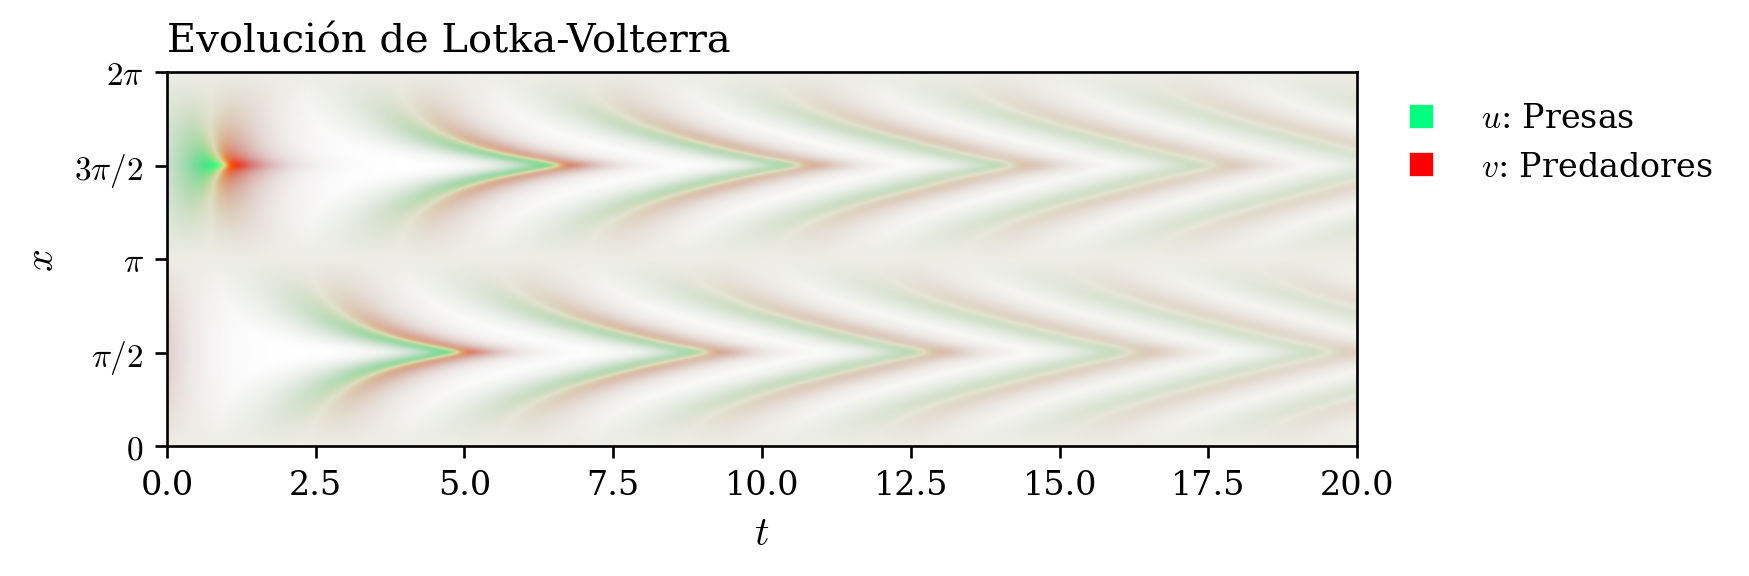

In [36]:
# Graficamos la evolución
plt.close("all")
%matplotlib inline
ax = plot_lotka_volterra(x_vals, t_vals, u, v)
plt.show()

Para este caso establecimos parámetros que cuentan una simetría entre ambas ecuaciones, es decir: la tasa de nacimientos de las presas es igual a la muerte de los predadores ($a=c$) y los acoplamientos entre especies y coeficientes de difusión son tambien iguales para ambas ecuaciones ($b = d$, $D_1 = D_2$).

Partiendo de estas condiciones iniciales senoidales podemos observar un comportamiento ciclico a lo largo del tiempo. Esto se debe a que la densidad de presas aumenta más en las regiones donde estas tienen valores iniciales más altos (y simultaneamente más bajos de predadores), mientras que por otro lado, debido a la difusión y a que el número de predadores aumenta en regiones donde hay alta densidad de presas, se observa que el crecimiento de la densidad de predadores 'sigue' al de presas. Una vez que el número de predadores iguala al de presas, la población de estas últimas disminuye abruptamente en esa región. Esta dinámica se repite de forma ciclica con cierto grado de atenuamiento.

#### Extra: Notas sobre el método de visualización

Para visualizar de manera simultanea la evolución de $u(x, t)$ y de $v(x, t)$ exploramos varias alternativas.


Primero repetimos el tipo de gráfico que veniamos trabajando en los ejercicios anteriores, donde se grafican las soluciones como imagenes 2D con el color representando el valor de la función en cada punto del espacio (eje vertical) y el tiempo (eje horizontal).

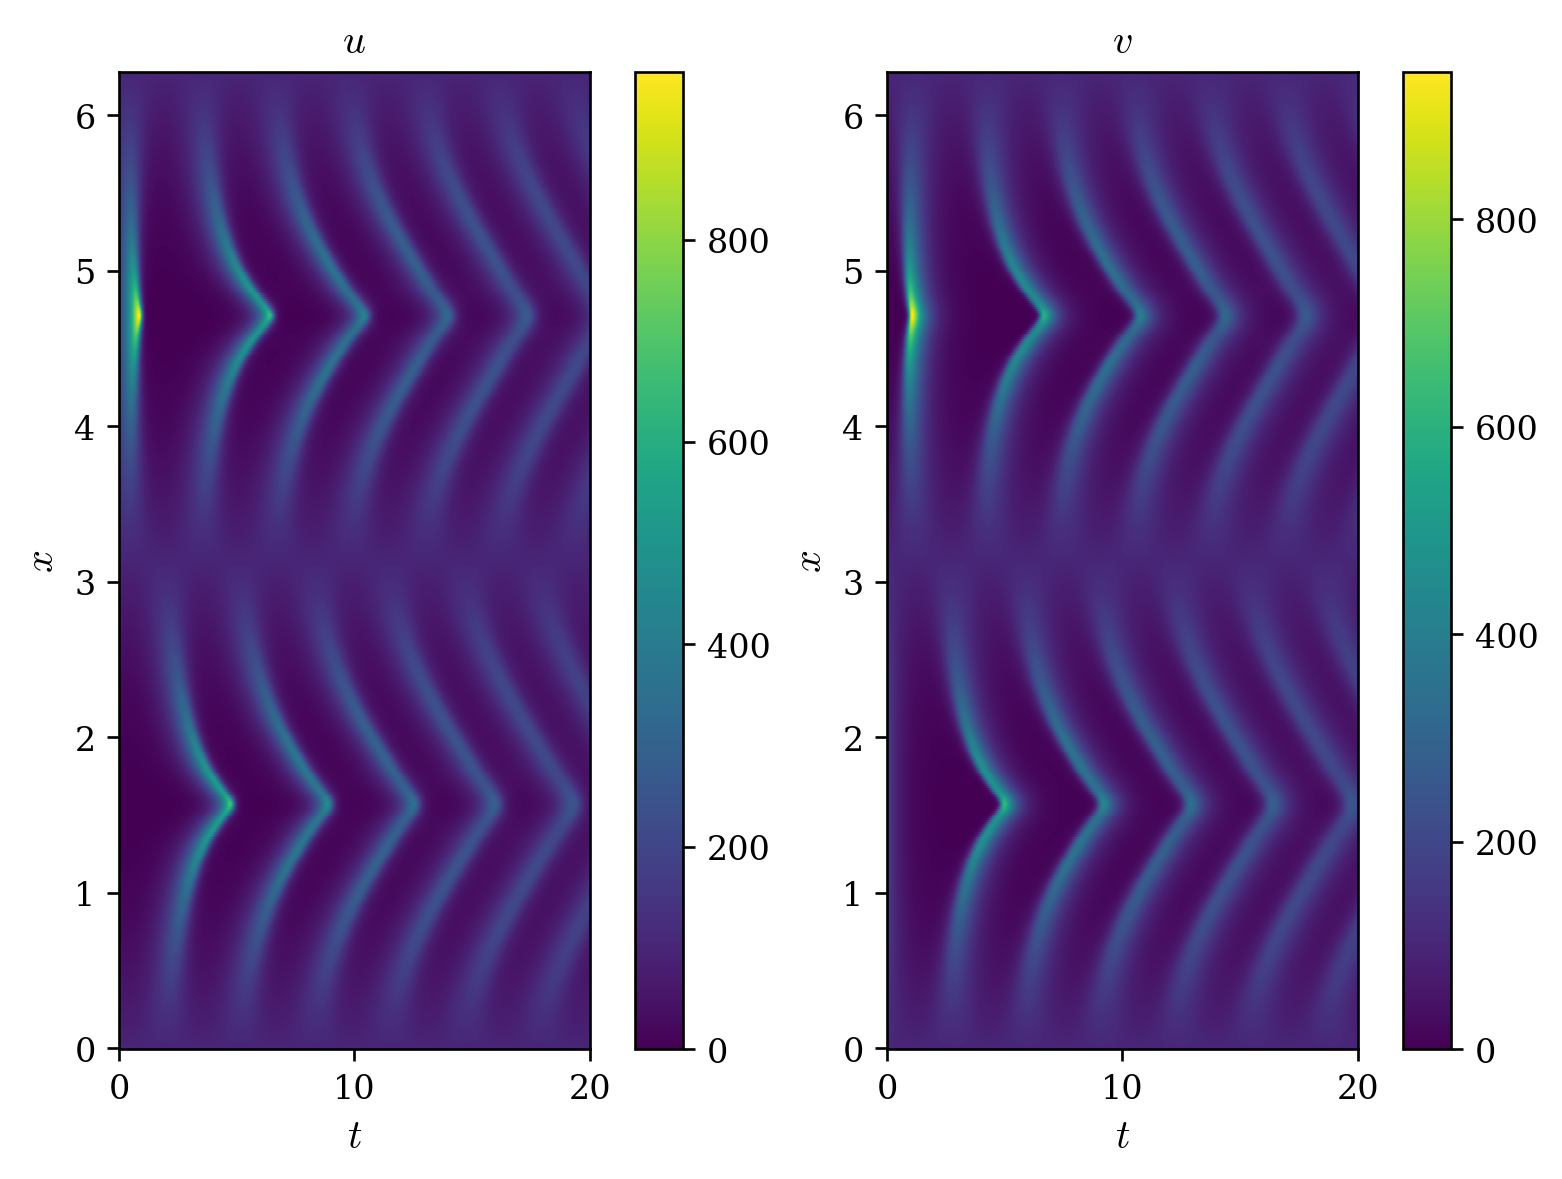

In [8]:
# Graficos individuales
plt.close("all")
%matplotlib inline
fig, axs = plt.subplots(1, 2, constrained_layout=True)
xx_vals, tt_vals = np.meshgrid(x_vals, t_vals, indexing='ij')
for ax, var, var_name, color in zip(axs, [u, v], 'uv', ['viridis', 'viridis']):
    colormap = ax.pcolormesh(tt_vals, xx_vals, var, cmap=color, alpha=1)
    ax.set_xlabel("$t$")
    ax.set_ylabel("$x$")
    ax.set_title(f'${var_name}$')
    plt.colorbar(colormap, ax=ax)
plt.show()

Si bien este método permite observar la dinámica de cada especie por separado sin problemas, resulta muy dificil interpretar la interacción entre poblaciones de esta manera ya que hay que mirar dos regiones distintas para identificar el mismo punto en el tiempo y espacio.

Como alternativa exploramos superponer las soluciones de ambas especies en un mismo gráfico mostrando únicamente las curvas de nivel de las superficies que representan las soluciones.

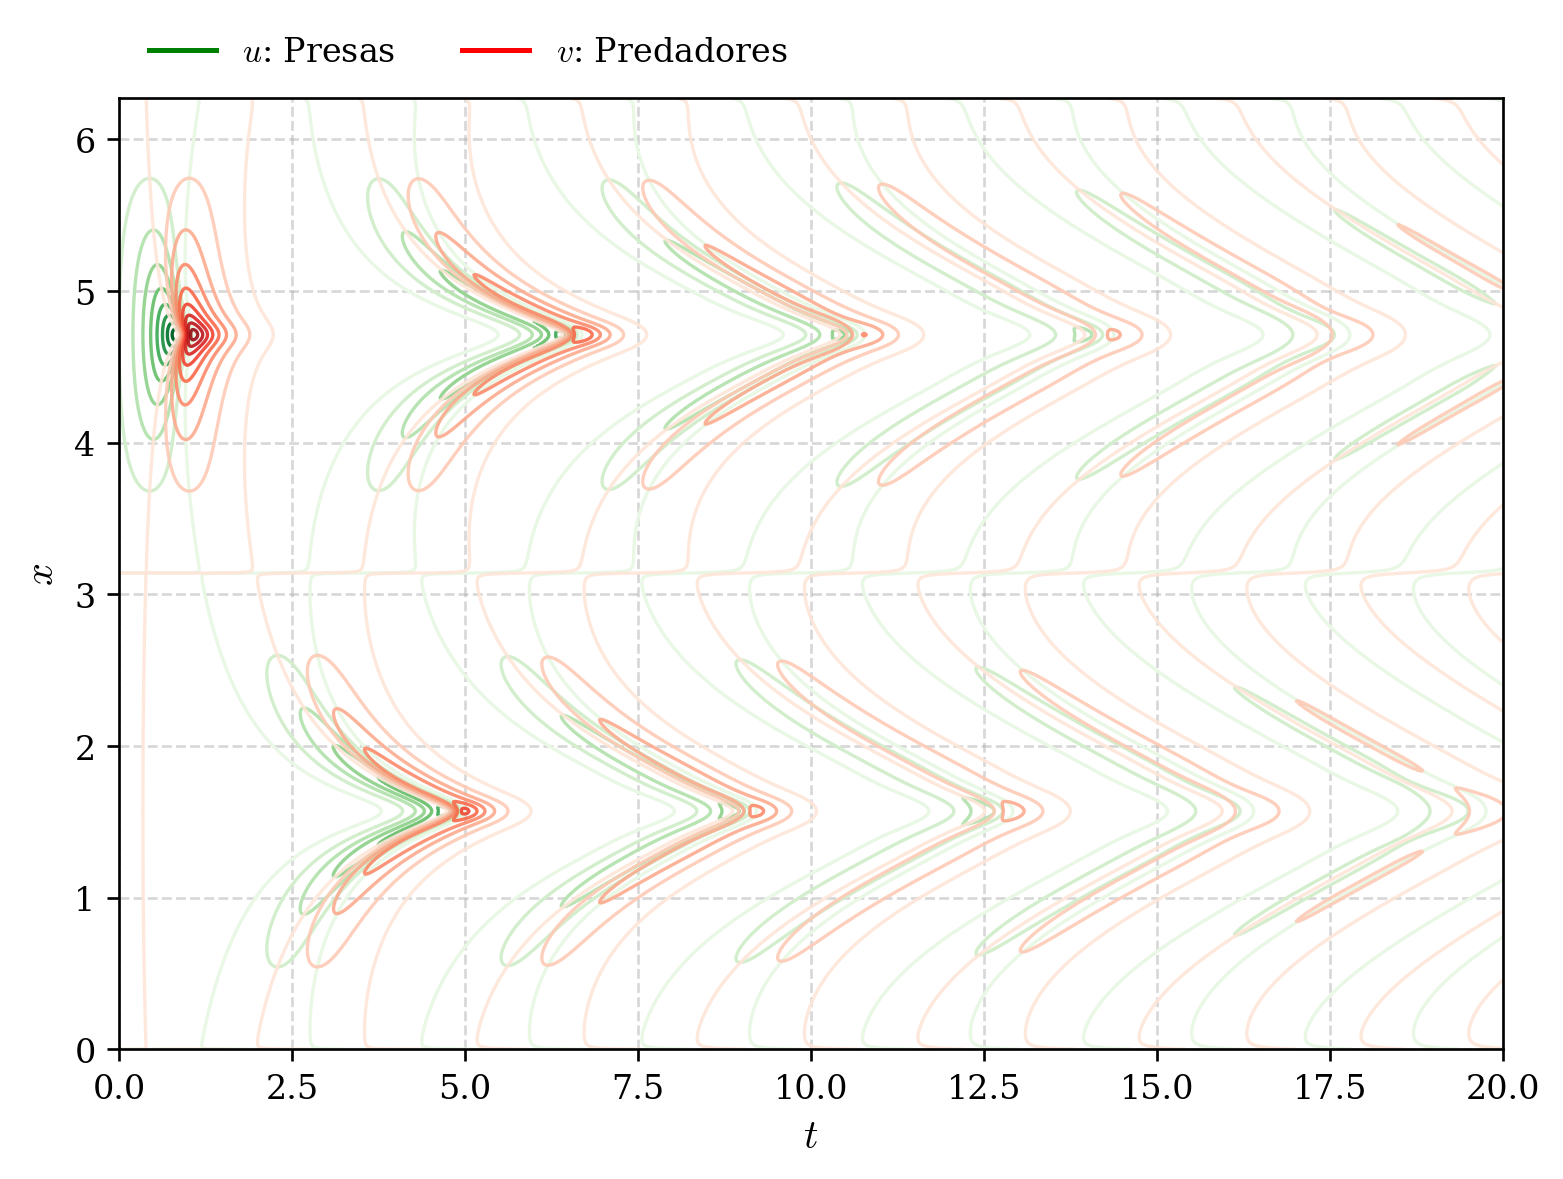

In [9]:
# Plot u y v como curvas de nivel
plt.close("all")
%matplotlib inline
fig, ax = plt.subplots(1, 1, constrained_layout=True)
xx_vals, tt_vals = np.meshgrid(x_vals, t_vals, indexing='ij')

# ax.contourf(tt_vals, xx_vals, u, cmap="Greens", levels=10, alpha=0.25)
# ax.contourf(tt_vals, xx_vals, v, cmap="Reds", levels=10, alpha=0.25)
ax.contour(tt_vals, xx_vals, u, cmap="Greens", levels=10, alpha=1, linewidths=1)
ax.contour(tt_vals, xx_vals, v, cmap="Reds", levels=10, alpha=0.9, linewidths=1)
ax.plot([], [], "g", label ='$u$: Presas')
ax.plot([], [], "r", label ='$v$: Predadores')
ax.legend(loc="lower left", bbox_to_anchor=(0, 1), frameon=False, ncol=2)
ax.set_xlabel("$t$")
ax.set_ylabel("$x$")
ax.grid(ls="--", alpha=0.5)
plt.show()

De esta manera se puede observar la dinámica de ambas especies en un mismo gráfico, permitiendo notar cómo los predadores se concentran en las regiones que instantes atras tenían una alta densidad de presas. Sin embargo, al trazar curvas de nivel se hace más ambigua la interpretación de la dinámica de cada especie por separado dado que las curvas de una quedan tapadas por las de la otra. Además notamos que la visualización de las curvas de nivel no es muy intuitiva para este tipo de problema dado que las formas de las curvas confunden la interpretación de una dinámica temporal.

Juntando entonces ambos enfoques llegamos a la siguiente visualización dónde en una misma imagen se usa el canal de color rojo para representar la evolución de la densidad de predadores y los canales de color verde y azul para representar la evolución de la densidad de presas. De esta manera se puede observar la superposición entre ambas poblaciones para visualizar la interacción, mientras que los colores no se tapan entre sí permitiendo estudiar la dinámica individual de cada especie por separado.

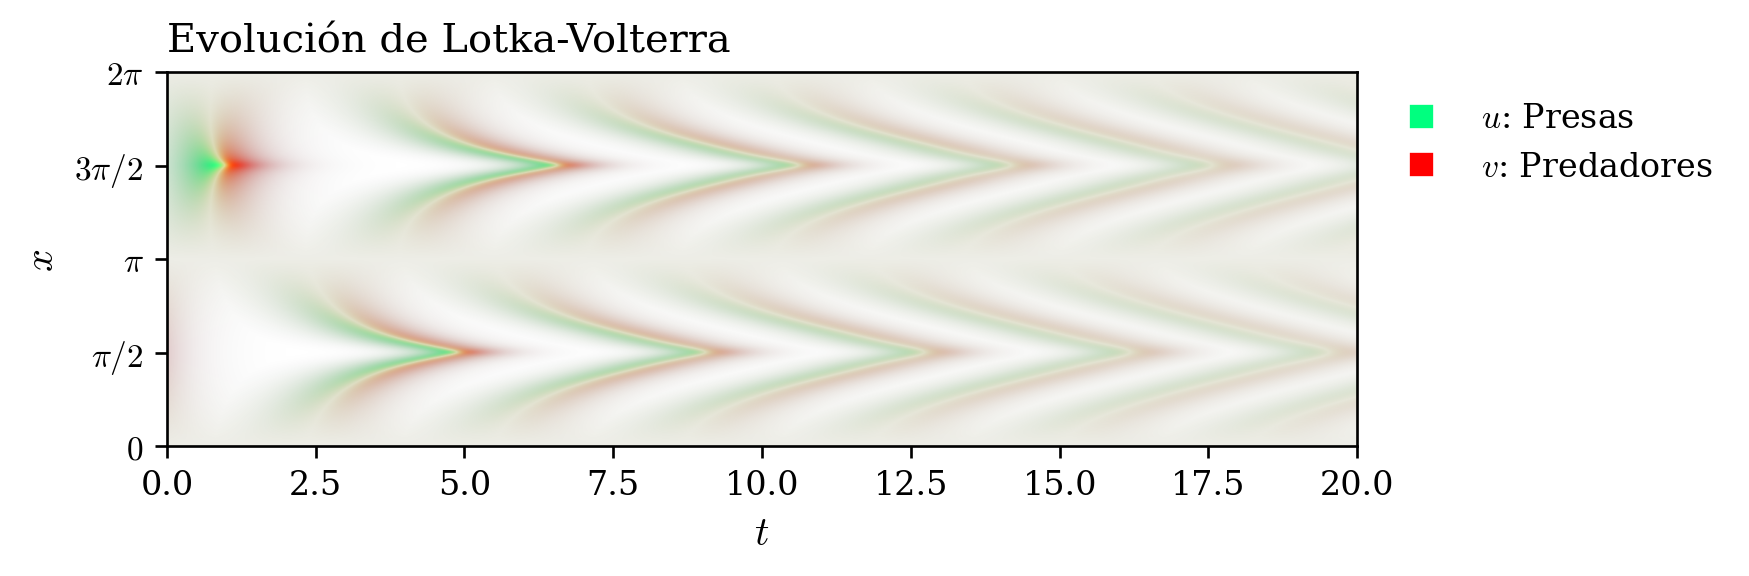

In [10]:
# Graficamos las soluciones mapeando v y u a los canales R y GB respectivamente
plt.close("all")
%matplotlib inline
ax = plot_lotka_volterra(x_vals, t_vals, u, v)
plt.show()

Este método resultó muy intuitivo, rápido de ejecutar y adaptable para visualizar la dinámica de las poblaciones permitiendo definir cómo los valores de $u$ y $v$ se mapean a los canales de color y opacidad. Por los mismos motivos este método es el menos fiel cuantitativamente a los datos, careciendo de una escala explicita entre los colores y la magnitud de $u$ y $v$. Aún así este resultó el más adecuado para el análsis cualitativo que buscamos realizar, permitiendo visualizar la superposición entre poblaciones para todos los puntos y tiempos a la vez.

Por último también exploramos animar las soluciones para poder observar la dinámica de manera más intuitiva. Este enfoque permite observar explicitamente las soluciones en función de la posición y su evolución en el tiempo. Sin embargo, dado que la dinámica de las poblaciones es muy rápida, la animación resultó muy dificil de interpretar además de presentar bugs en VScode. Por este motivo decidimos no incluir las animaciones en el informe.

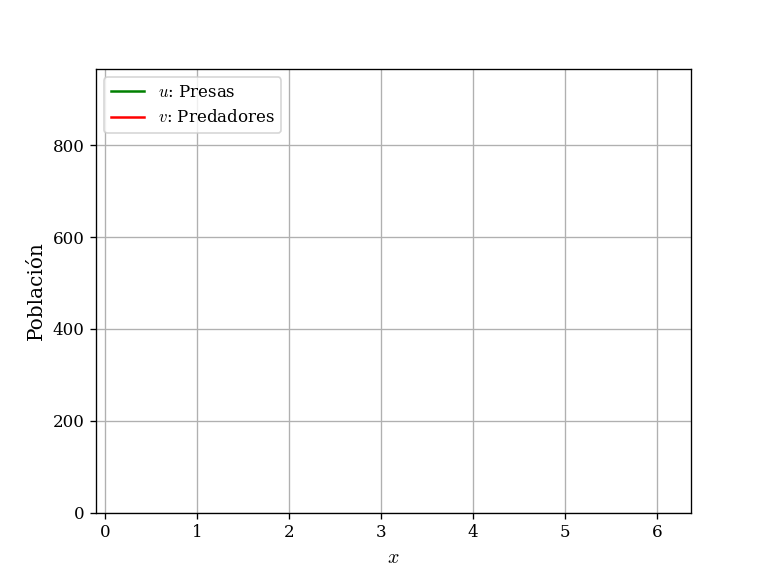

In [11]:
# Animación
plt.close("all")
%matplotlib widget
fig, ax = plt.subplots(num=1, clear=True)
ax.set_xlabel('$x$')
ax.set_ylabel('Población')
ax.set_xlim(min(x_vals)-0.1,max(x_vals)+0.1)
ax.set_ylim(np.min(np.array([u,v]))-0.1, np.max(np.array([u,v]))+0.1)
ax.grid("True")

linea1, = ax.plot([],[],'-', color = "g", label="$u$: Presas")
linea2, = ax.plot([],[],'-', color = "r", label="$v$: Predadores")
ax.legend(loc="upper left", bbox_to_anchor=(0, 1))

duracion_animacion = 10  # s
frames_per_sec = 30  # s^-1
anim_step = t_vals.size//(frames_per_sec*duracion_animacion)
def graficar(i): # En esta función defino los frames de la animación
    linea1.set_data(x_vals, u[:, i*anim_step])
    linea2.set_data(x_vals, v[:, i*anim_step])
    ax.set_title(f"i = {i}, t = {t_vals[i*anim_step]:.2f} / {t_vals[-1]:.0f}")
    return (linea1, linea2)

anim = animation.FuncAnimation(fig, graficar,
                               frames=(frames_per_sec*duracion_animacion),
                               interval=1000//frames_per_sec, blit=True,)
# anim.save("animation.mp4", fps=24)
# anim
plt.show()


### b)

A continuación estudiamos los efectos de la difusión sobre el sistema. Para ello consideramos las combinaciones posibles entre una difusión baja de $5\times 10^{-4}$ y una difusión alta de $5\times 10^{-2}$.

Pasos de Pseudo-Espectral:   0%|          | 0/20000 [00:00<?, ?it/s]

Pasos de Pseudo-Espectral:   0%|          | 0/20000 [00:00<?, ?it/s]

Pasos de Pseudo-Espectral:   0%|          | 0/20000 [00:00<?, ?it/s]

Pasos de Pseudo-Espectral:   0%|          | 0/20000 [00:00<?, ?it/s]

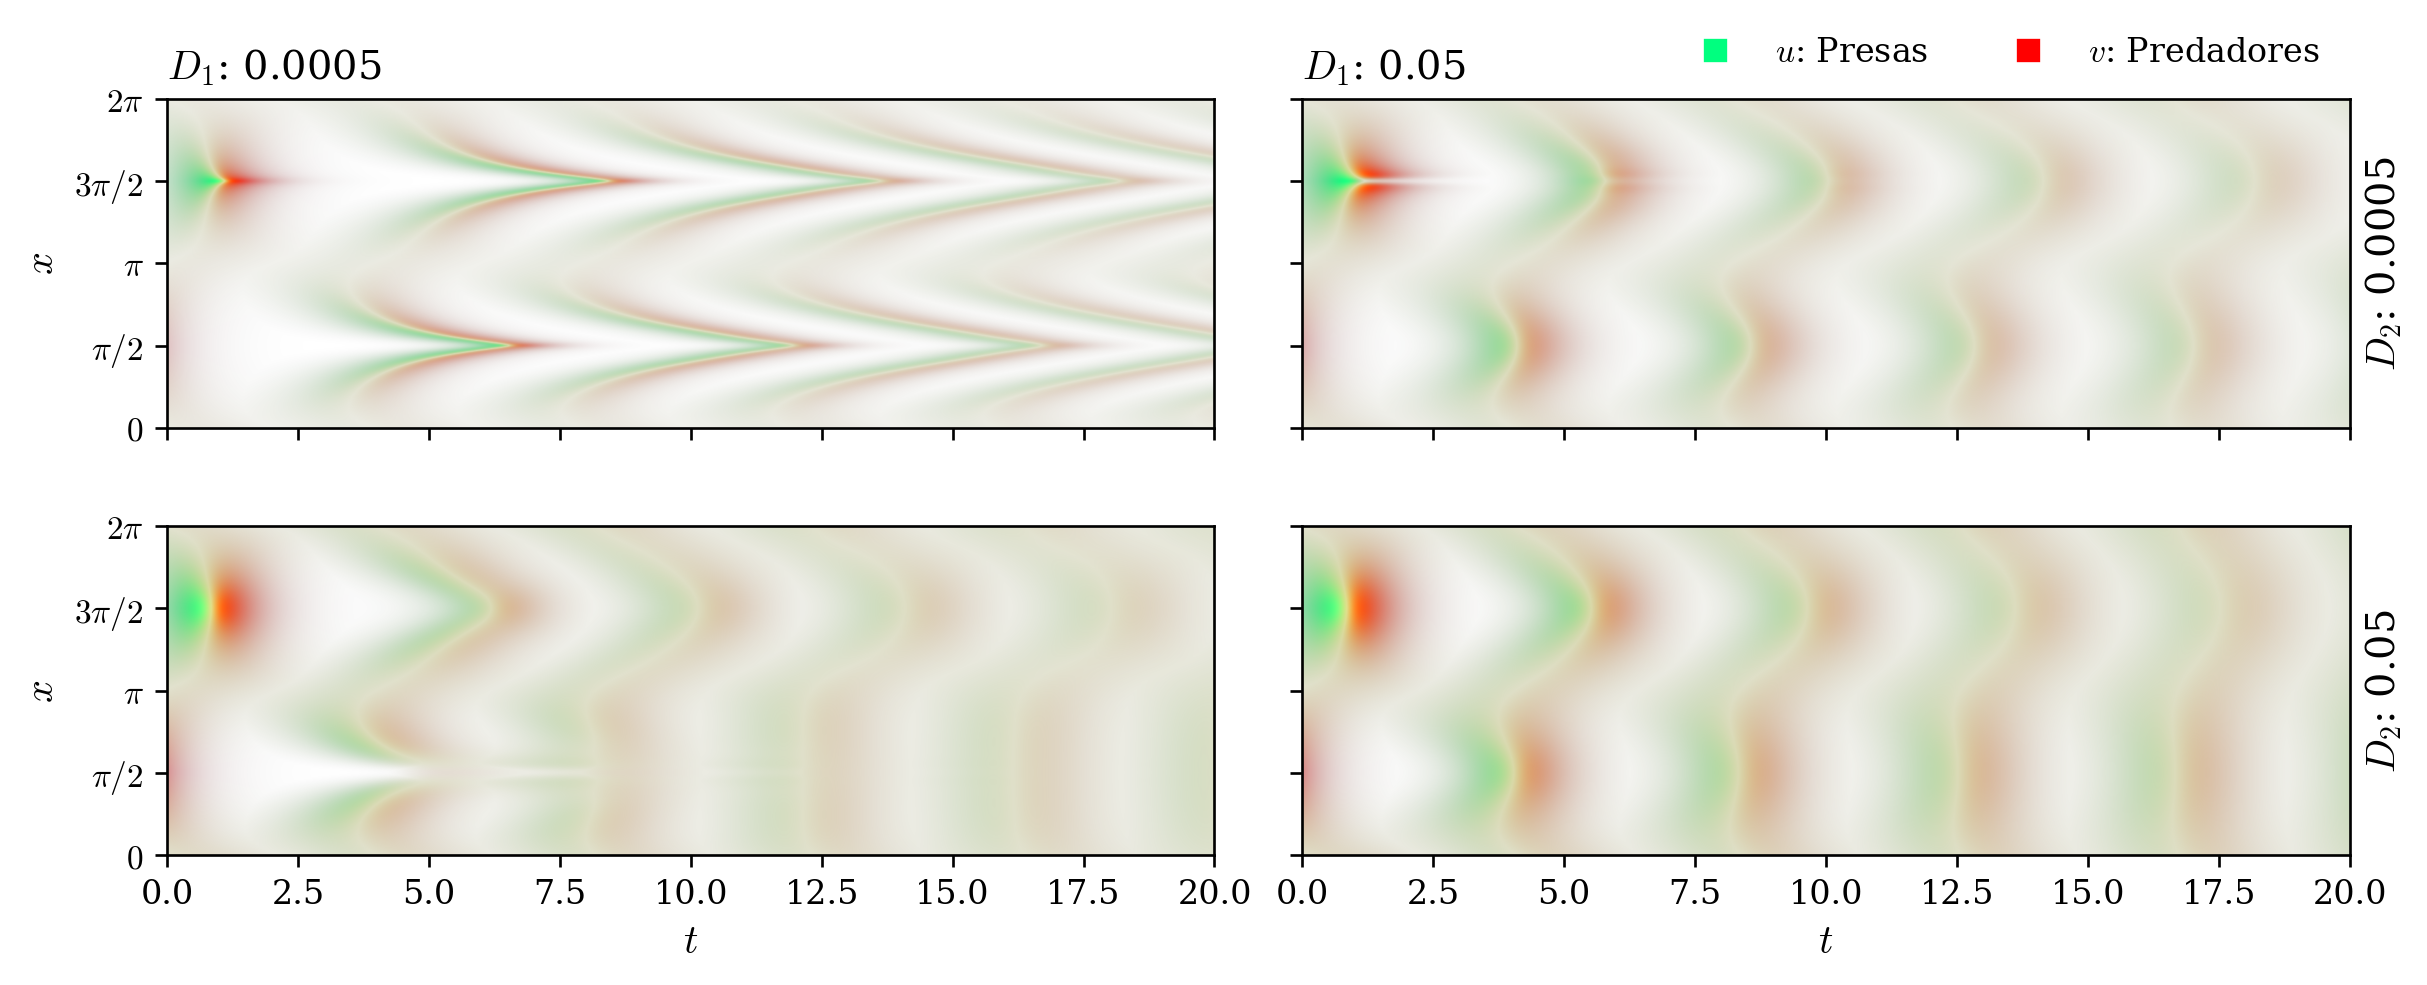

In [37]:
plt.close("all")
%matplotlib inline
        
difusion_vals = np.array([5e-4, 5e-2])
fig, axs = plt.subplots(difusion_vals.size, difusion_vals.size, figsize=(10, 4),
                        constrained_layout=True,
                        sharex=True, sharey=True, squeeze=False)
for ax_col, dif_1 in zip(axs.T, difusion_vals):
    ax_col[0].set_title(f'$D_1$: {dif_1}', loc="left")
    for ax, dif_2 in zip(ax_col, difusion_vals):
        x_vals, t_vals, u, v = lotka_volterra_pseudoespectral(
            u0=u0,
            v0=v0,
            lv_params=[
                dif_1,  # D1: Difusión de u
                dif_2,  # D2: Difusión de v
                1.6,  # a: Tasa de crecimiento de u
                0.02,  # b: Tasa de interacción de v sobre u
                1.6,  # c: Tasa de decrecimiento de v
                0.02,  # d: Tasa de interacción de u sobre v
            ],
            tf=20,
            dt=1e-3,
            nx=512,
        )
        plot_lotka_volterra(x_vals, t_vals, u, v, ax=ax, add_legend=False, add_labels=False)
for ax in axs[:, 0]:
    ax.set_ylabel("$x$")
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2 * np.pi])
    ax.set_yticklabels(["$0$", "$\pi/2$", "$\pi$", "$3\pi/2$", "$2\pi$"])
for ax, dif_2 in zip(axs[:, 1], difusion_vals):
    ax.set_ylabel(f"$D_2$: {dif_2}")
    ax.yaxis.set_label_position("right")
for ax in axs[-1, :]:
    ax.set_xlabel("$t$")


axs[0, 1].plot([], [], "s", c="springgreen", label ='$u$: Presas')
axs[0, 1].plot([], [], "s", c="red", label ='$v$: Predadores')
axs[0, 1].legend(loc="lower right", bbox_to_anchor=(1, 1), frameon=False, ncol=2)
plt.show()

En primer lugar, para el caso en que ambos presas y predadores tienen baja difusión se observa que hay un desplazamiento espacial muy claro de las poblaciones. Estas se acumulan en regiones concretas para cada tiempo. Este resultado se contrasta con el caso de difusión alta para ambas poblaciones. Para este caso se observa tambien que hay acumulación de la población pero la difusión hace que la distribución sea más suave, que no haya un contraste tan marcado.

Por otro lado, para el caso en que hay una población con alta difusión y otro con más baja difusión, se puede ver que para el caso en que la alta difusión la tienen las presas ($D_1 < D_2$), la magnitud de las soluciones decrece más rápidamente que en el resto de los casos (los colores se atenuan a tiempos menores). Mientras que en el caso contrario ($D_1 > D_2$) la evolución se asemeja más al de difusión alta para ambas poblaciones. Esto se relaciona con el hecho de que, como se observó en el punto $a)$, los predadores 'persiguen' a las presas en cada ciclo. Es decir, se acumulan en regiones en donde hay varias presas. Entonces, si estas últimas tienen una distribución más difusa, los predadores la replicaran, no así en el otro caso.

Para comprobar brevemente que estas observaciones no se limitan al caso computado arriba, se incluyen a continuación otra serie de ejemplos dónde se observan efectos similares aún bajo otras condiciones iniciales y variando los otros parámetros de las PDEs.

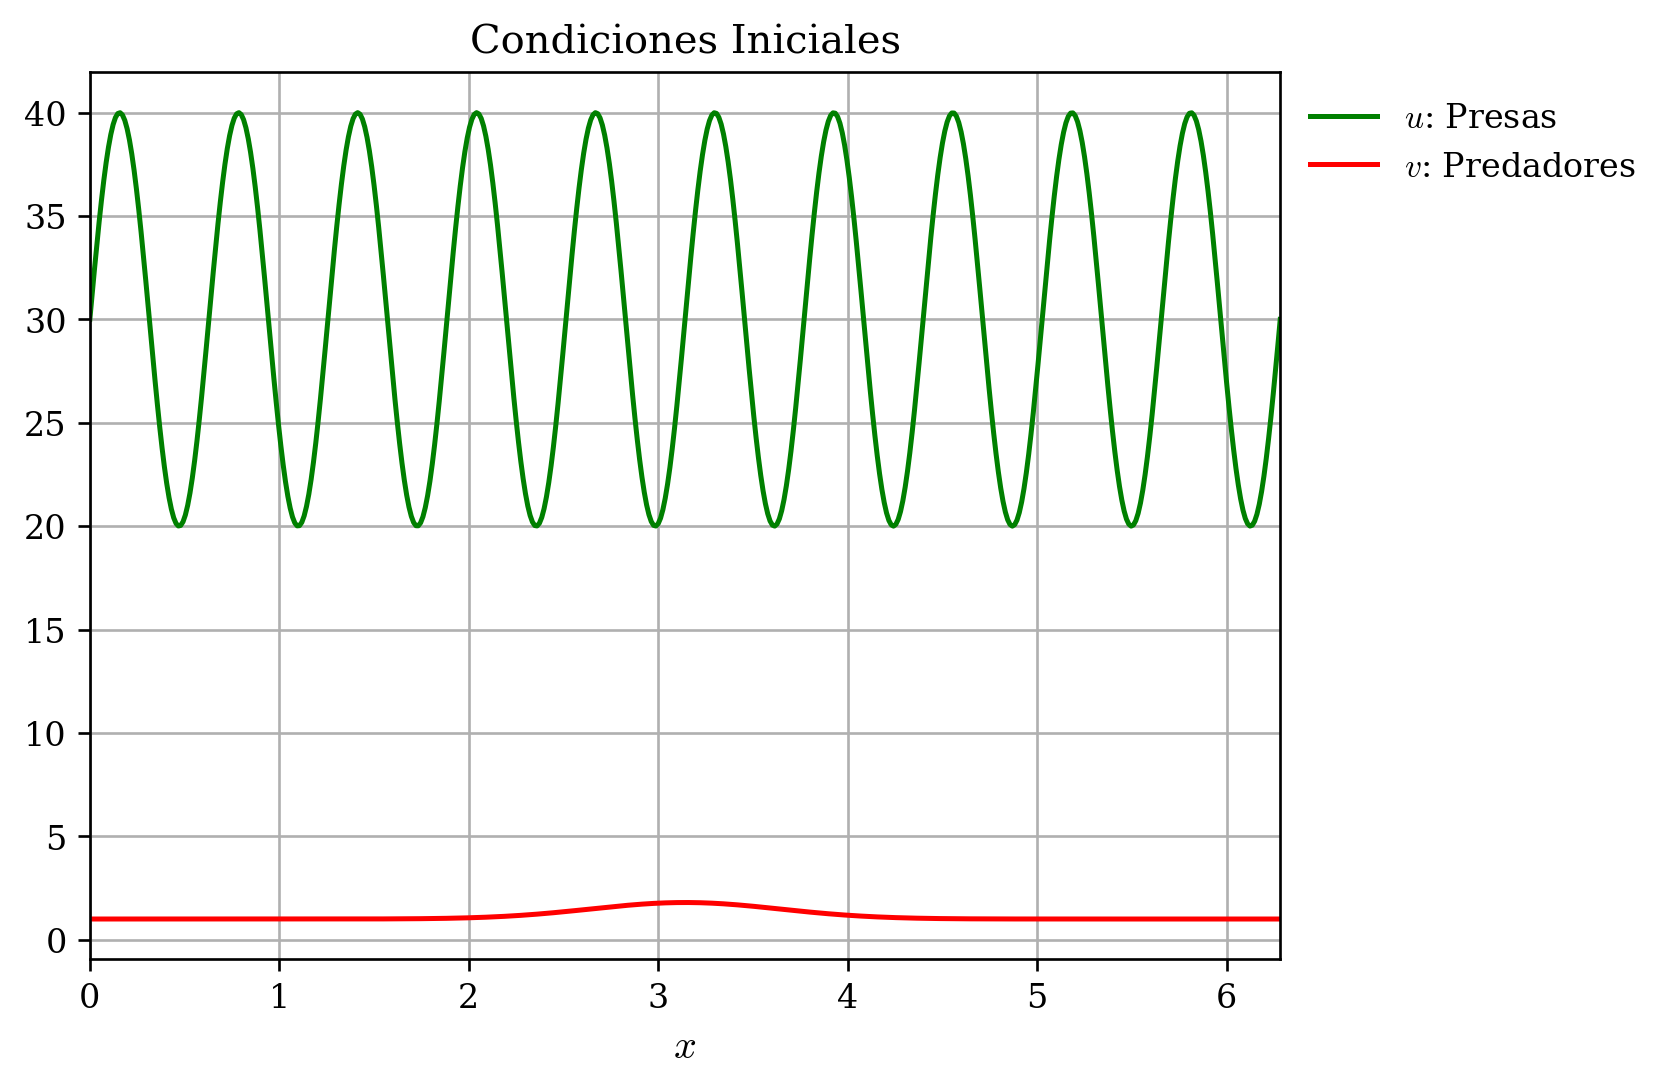

In [38]:
# Nuevas Condiciones Iniciales
plt.close("all")
%matplotlib inline
x_vals = np.linspace(0, 2*np.pi, 512)
plt.title('Condiciones Iniciales')
plt.plot(x_vals, 10*np.sin(10*x_vals) + 30, "g", label ='$u$: Presas')
plt.plot(x_vals, gaussian(x_vals, np.pi, 0.5) + 1, "r", label ='$v$: Predadores')
plt.grid()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
plt.xlabel('$x$')
plt.xlim(x_vals[0], x_vals[-1])
plt.show()

Pasos de Pseudo-Espectral:   0%|          | 0/20000 [00:00<?, ?it/s]

/tmp/ipykernel_17415/3314293124.py:12: RuntimeWarning: invalid value encountered in sqrt
  v_norm**(0.5),  # R : Canal rojo


Pasos de Pseudo-Espectral:   0%|          | 0/20000 [00:00<?, ?it/s]

Pasos de Pseudo-Espectral:   0%|          | 0/20000 [00:00<?, ?it/s]

Pasos de Pseudo-Espectral:   0%|          | 0/20000 [00:00<?, ?it/s]

/home/agustin/Documents/FCEN/2023_2do_Cuatrimestre/Sistemas_Complejos/chaos_env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


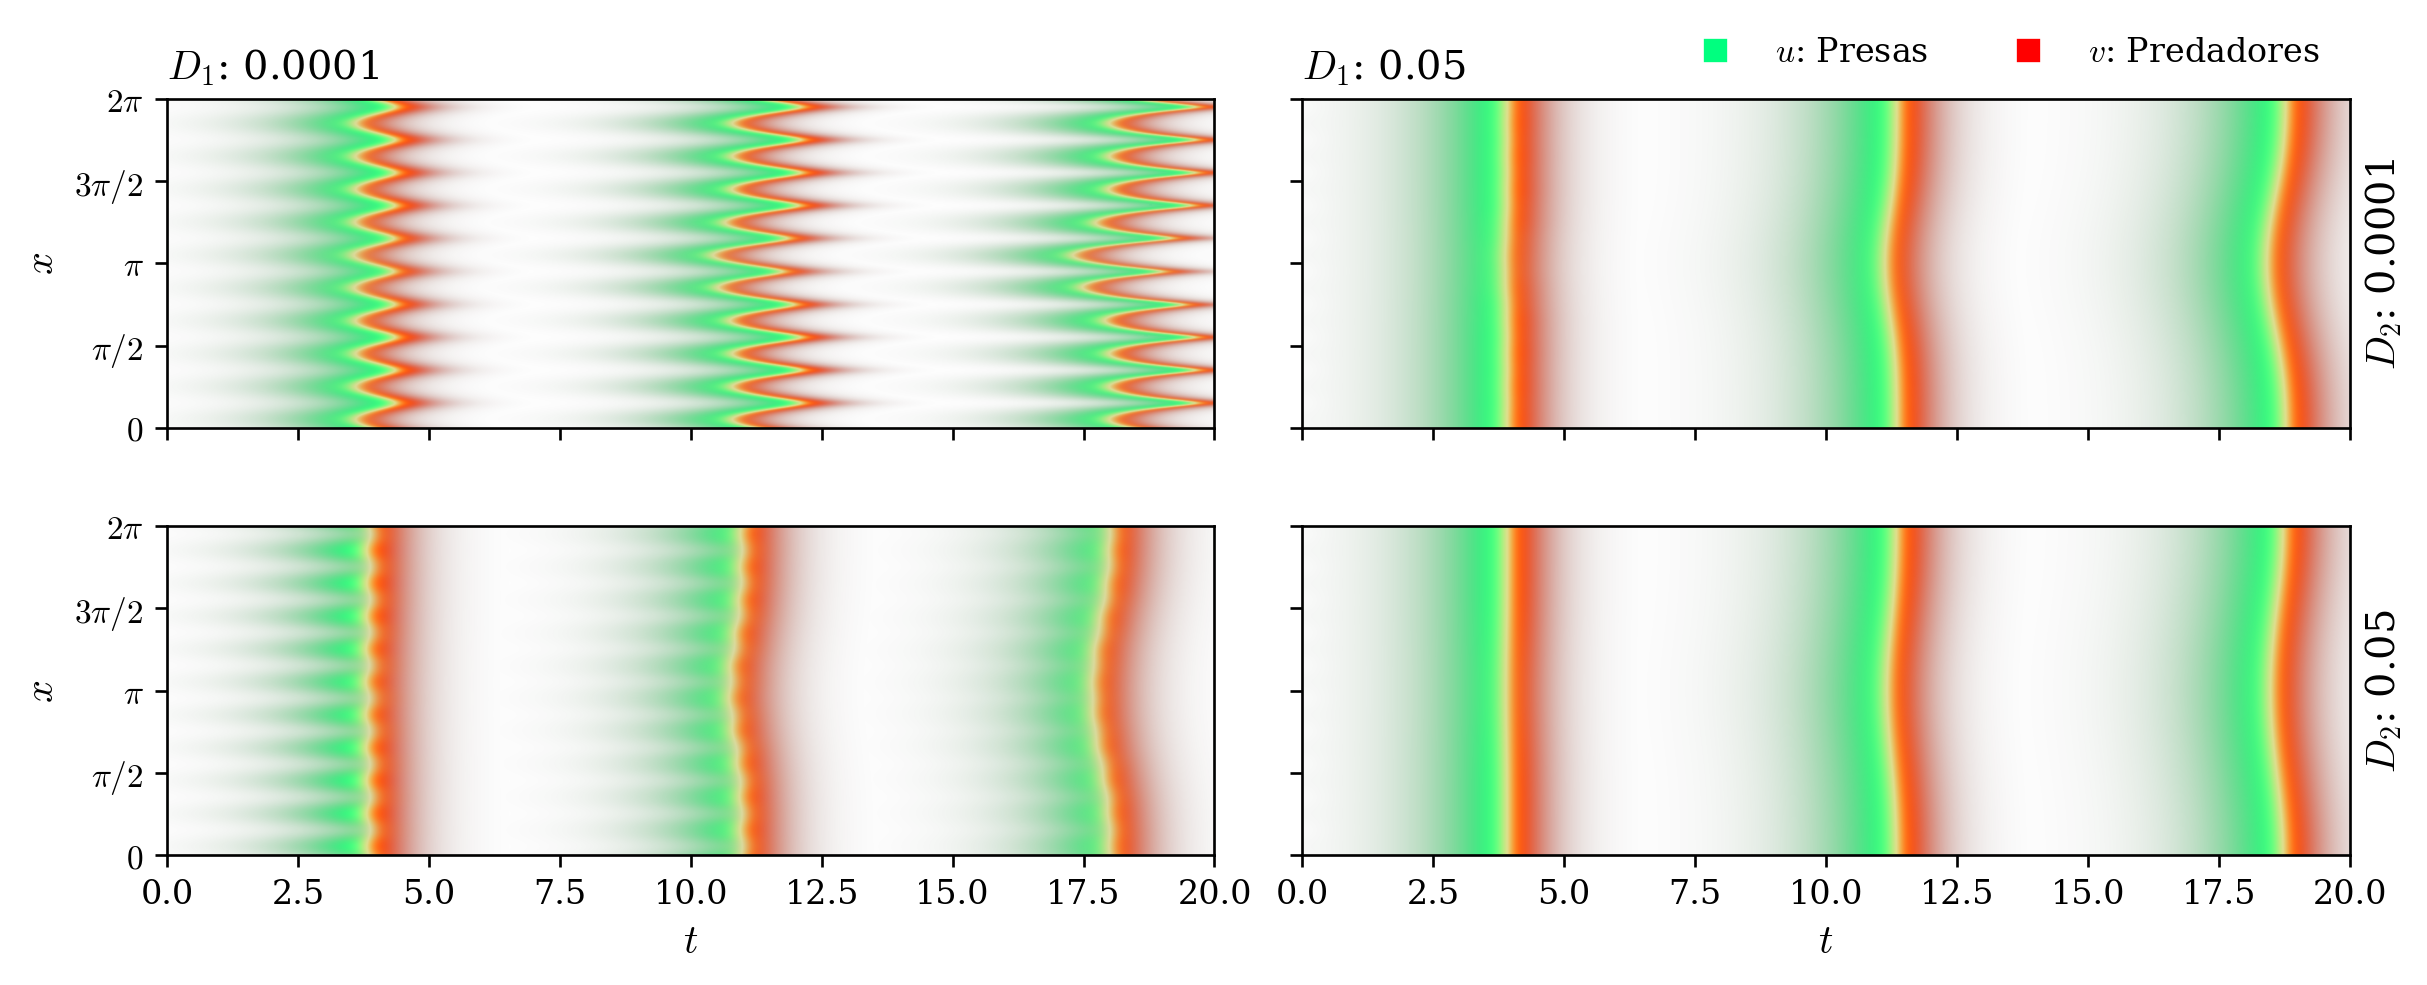

In [40]:
# Graficamos un nuevo grupo de soluciones
plt.close("all")
%matplotlib inline
        
difusion_vals = np.array([1e-4, 5e-2])
fig, axs = plt.subplots(difusion_vals.size, difusion_vals.size, figsize=(10, 4),
                        constrained_layout=True,
                        sharex=True, sharey=True, squeeze=False)
for ax_col, dif_1 in zip(axs.T, difusion_vals):
    ax_col[0].set_title(f'$D_1$: {dif_1}', loc="left")
    for ax, dif_2 in zip(ax_col, difusion_vals):
        x_vals, t_vals, u, v = lotka_volterra_pseudoespectral(
            u0=lambda x: 10*np.sin(10*x) + 30,
            v0=lambda x: gaussian(x, np.pi, 0.5) + 1,
            lv_params=[
                dif_1,  # D1: Difusión de u
                dif_2,  # D2: Difusión de v
                1,  # a: Tasa de crecimiento de u
                0.02,  # b: Tasa de interacción de v sobre u
                2,  # c: Tasa de decrecimiento de v
                0.01,  # d: Tasa de interacción de u sobre v
            ],
            tf=20,
            dt=1e-3,
            nx=512,
        )
        plot_lotka_volterra(x_vals, t_vals, u, v, ax=ax, add_legend=False, add_labels=False)
for ax in axs[:, 0]:
    ax.set_ylabel("$x$")
    ax.set_yticks([0, np.pi/2, np.pi, 3*np.pi/2, 2 * np.pi])
    ax.set_yticklabels(["$0$", "$\pi/2$", "$\pi$", "$3\pi/2$", "$2\pi$"])
for ax, dif_2 in zip(axs[:, 1], difusion_vals):
    ax.set_ylabel(f"$D_2$: {dif_2}")
    ax.yaxis.set_label_position("right")
for ax in axs[-1, :]:
    ax.set_xlabel("$t$")


axs[0, 1].plot([], [], "s", c="springgreen", label ='$u$: Presas')
axs[0, 1].plot([], [], "s", c="red", label ='$v$: Predadores')
axs[0, 1].legend(loc="lower right", bbox_to_anchor=(1, 1), frameon=False, ncol=2)
plt.show()

Consistentemente con lo observado anteriormente, la difusión de las presas ($D_1$) es la principal responsable de los cambios cualitativos en la dinámica, mientras que la difusión de los predadores ($D_2$) tiene un efecto menor debido a que la dinámica de estos tiende a imitar (con un desfasaje) la de las presas.

Intuitivamente, podríamos decir que si las presas son más lentas que los predadores ($D_1 < D_2$) entonces estos últimos logran agotar las presas disponibles en cada región antes de que estas puedan difundirse a otras regiones, lo que luego causa un descenso en la población de predadores que no logran encontrar comida. Por otro lado, si las presas son más rápidas que los predadores ($D_1 > D_2$) entonces estas logran difundirse a otras regiones antes de que los predadores puedan agotarlas, alcanzando una mayor homogeneidad en el proceso y eventualmente un equilibrio ciclico entre ambas poblaciones como se describió en 1.a).

# **Ejercicio 2: Modelo para la propagación del fuego, ecuación de Kuramoto-Sivashinsky**

---




La ecuación de Kuramoto-Sivashinsky viene dada por

$$ u_t = -u_{xx} -u_{xxxx} - (u_x)^2/2 $$

Derivando respecto a x y tomando $v = u_x$ se tiene

$$ v_t = -v_{xx} -v_{xxxx} - vv_x, $$

de donde puede verse que el término $v_{xx}$ representa la reacción, que $v_{xxxx}$ es el término de disipación y $vv_x$ es el término advectivo.


**a**) Qué simetrías tiene esta ecuación? Basado en esto, y dado un dominio de longitud L y cdc periódicas elegí una base de Fourier y escribí una proyección de Galerkin de esta ecuación, hasta llegar a la expresión explícita para la evolución temporal del sistema.

**b**) Escribi explícitamente los primeros cuatro modos y estudiá la primera bifrucación del sistema (a dos modos). A partir de esto, que esperás que pase al agregar mas modos?

**c**) Integrá la ecuación numéricamente con condiciones de contorno periódicas, utilizando un método numérico a elección. *Ayuda: Para trabajar con una variable $x \in [0,2\pi)$ y poder cambiar fácilmente la longitud total del recinto a *$2\pi L$, *redefini* $x'=x/L$ y $t'=t/L^2$. *La ecuación que se obtiene entonces es*

$$ u_{t'} = -u_{x'x'} -u_{x'x'x'x'}/L^2 - (u_{x'})^2/2 $$

Qué pasa si se extiende el dominio espacial a $n\pi$ (probá con distintos L)? Explicá detalladamente la dinámica que ves en relación al item previo (Ayuda: usa gráficos 2D de la solución obtenida). Es posible caracterizar las soluciones con unos pocos modos?

Para las $u(x,t)$ obtenidas numéricamente, puede resultar de mucha utilidad trabajar con la función de estructura de orden 2 de la velocidad, dada por

$$ S_2(l,t) = < [u(x+l,t)-u(x,t)]^2 > = <\delta u_l^2>  $$

la cual tiene un vínculo directo con el espectro de Energía  en el espacio de Fourier $E(k)$ ($S_2$ es la "energía en el espacio real"). De esta forma, ya sea con $E(k)$ o $S_2$, es posible argumentar acerca de la dinámica del sistema en términos de la cantidad de modos que estan excitados en la proyección de Galerkin, y de cual es su amplitud. Pero mas aún, en sistemas autosimilares, es posible hallar la dimension fractal del sistema. Si además el sistema es monofractal, toda la estadistica del sistema queda unívocamente determinada por $S_2$.^

**d**) Calculá la función de estructura $S_2(l)$ y el espectro de energía $E(k)$.

**e**) A partir de estos, hallá un rango de autosimilaridad para el cual puedan escribirse leyes de scala de la forma $E(k)\sim k^{\alpha}$ y $S_2(l)\sim l^{\beta}$. De acuerdo entonces a las soluciones numéricas, cuánto valen $\alpha$ y $\beta$? Qúe relación guardan entre si? Es lo esperado?

~~**f**) Opcional: Hallá la dimensión fractal, D, del sistema. Argumentá. El valor obenido refleja las estructuras que ves en los gráficos de $u(x,t)$?~~










### a)

Podemos ver que la ecuación de Kuramoto-Sivashinsky es invariante bajo traslaciones ($x \to x + \alpha$ y $u \to u +\beta$) dado que expresada en términos de $u$ la ecuación solo presenta términos con derivadas de $u$ por lo que no se contienen las constantes. De forma similar, la ecuación es invariante ante reflexiones espaciales ($x \to -x$) dado los términos con derivadas en $x$ aparecen: o bien elevados a una potencia par o bien elevados al cuadrado (anulandose los signos negativos que podrían aparecer).

Considerando entonces las simetrías mencionadas, y dado un dominio de longitud $L$ y condiciones de controno periódicas, podemos elegir una base de Fourier según
$$\varphi_k(x) = \exp\left(i k \frac{2\pi}{L} x\right),$$
de manera que la solución puede expresarse cómo
$$u(x,t) = \sum_{k=0}^{\infty}a_k(t)\varphi_k(x).$$

Luego, en la base de Fourier las derivadas cumplen las siguientes identidades:
$$\partial_{x} \varphi_k = i k \frac{2\pi}{L} \varphi_k$$
$$\partial_{xx} \varphi_k = -\left(k \frac{2\pi}{L}\right)^2 \varphi_k$$
$$\partial_{xxxx} \varphi_k = \left(k \frac{2\pi}{L}\right)^4 \varphi_k$$


Así, reemplazando estas identidades podemos escribir la proyección de Galerkin de la ecuación de Kuramoto-Sivashinsky:
$$\sum_{k=0}^{\infty}\dot{a}_k(t)\varphi_k(x) = \sum_{k=0}^{\infty}a_k(t)\left(k \frac{2\pi}{L}\right)^2\varphi_k(x) -\sum_{k=0}^{\infty}a_k(t)\left(k \frac{2\pi}{L}\right)^4\varphi_k(x) - \frac{1}{2}\left(\sum_{k=0}^{\infty}a_k(t)i k \frac{2\pi}{L}\varphi_k(x)\right)^2.$$

Multiplicando por $\varphi_l(x)^*$ e integrando en el dominio, podemos usar la condición de ortogonalidad $\int_0^L \varphi_l(x)^* \varphi_k(x)\,\mathrm{d}x = L \delta_{kl}$ para obtener:
$$\begin{align*}
\sum_{k=0}^{\infty}\dot{a}_k(t) L \delta_{kl} = \sum_{k=0}^{\infty}a_k(t)\left(k \frac{2\pi}{L}\right)^2 L \delta_{kl} -\sum_{k=0}^{\infty}a_k(t)\left(k \frac{2\pi}{L}\right)^4 L \delta_{kl}& - \frac{1}{2}\int\limits_0^L\varphi_l(x)^*\left(\sum_{k=0}^{\infty}a_k(t) i k \frac{2\pi}{L} \varphi_k(x)\right)^2\,\mathrm{d}x \\
... & + \frac{1}{2}\sum_{k}^{\infty}\sum_{j}^{\infty}\int\limits_0^L\varphi_{-l}(x)a_k(t) a_j(t) k j \frac{4\pi^2}{L^2} \varphi_{k + j}(x)\,\mathrm{d}x \\
... & + \frac{1}{2}\sum_{k}^{\infty}\sum_{j}^{\infty} a_k(t) a_j(t) k j \frac{4\pi^2}{L^2} L \delta_{k+j, l} \\
\dot{a}_l(t) = \left(l \frac{2\pi}{L}\right)^2 a_l(t) - \left(l \frac{2\pi}{L}\right)^4 a_l(t) & +  \frac{1}{2}\sum_{k}^{\infty} a_k(t) a_{l-k}(t) k (l-k) \frac{4\pi^2}{L^2} \\
\dot{a}_l(t) = \left[1 - \left(l \frac{2\pi}{L}\right)^2\right] \left(l \frac{2\pi}{L}\right)^2 a_l(t) & +  \frac{1}{2}\sum_{k}^{\infty} a_k(t) a_{l-k}(t) k (l-k) \frac{4\pi^2}{L^2}
\end{align*}$$

### b)

Truncando la expresión hasta el modo $l = 3$ podemos desarrollar los primeros cuatro modos.

Desarrollamos el modo $l = 0$:
$$\begin{align*}
\dot{a}_0(t) &= - \frac{1}{2}\sum_{k = 1}^{\infty} a_k(t) a_{-k}(t) k^2 \frac{4\pi^2}{L^2} \iff \dot{a}_0(t) = - \frac{1}{2}\sum_{k = 1}^{3} |a_{k}(t)|^2 k^2 \frac{4\pi^2}{L^2} \\
\iff \dot{a}_0(t) &= -\left[|a_{1}(t)|^2 + 4|a_{2}(t)|^2 + 9|a_{3}(t)|^2\right] \frac{2\pi^2}{L^2}
\end{align*}$$
dónde usamos qué $a_{-k}(t) = a_{k}(t)^* / a_k(t) a_{-k}(t) = |a_k(t)|^2$. Notando que los términos de la sumatoria son reales positivos, podemos decir que este modo recibe energía de todos los demás.

Luego, desarrollando los modos $l = 1, 2, 3, 4$:
$$\begin{align*}
\dot{a}_1(t) = \left[ \left(1 - \left(\frac{2\pi}{L}\right)^2\right) a_1(t) - a_{2}(t)a_{1}(t)^* - 3 a_{3}(t)a_{2}(t)^* - 12 a_{3}(t)^{*}a_{4}(t)\right] \frac{4\pi^2}{L^2}\\
\end{align*}$$
$$\dot{a}_2(t) = \left[ 4 \left(1 - \left(\frac{4\pi}{L}\right)^2\right)  a_2(t)  + \frac{1}{2} |a_{1}(t)|^2 - \frac{3}{2} a_{3}(t)a_{1}(t)^* - 8 a_{2}(t)^{*}a_{4}(t)\right] \frac{4\pi^2}{L^2}$$
$$\dot{a}_3(t) = \left[ 9 \left(1 - \left(\frac{6\pi}{L}\right)^2\right) a_3(t) + a_{1}(t)a_{2}(t) - 4 a_{1}(t)^{*}a_{4}(t)\right]\frac{4\pi^2}{L^2}$$
$$\dot{a}_4(t) = \left[ 16 \left(1 - \left(\frac{8\pi}{L}\right)^2\right) a_4(t) + 9 a_{1}(t)a_{3}(t) + 4|a_{2}(t)|^2\right]\frac{4\pi^2}{L^2}$$

se puede notar que el término $k = 0$ no aporta a la sumatoria, haciendo que este modo no "dé energía" a ningún otro.


Si queremos estudiar la bifurcación del sistema a dos modos nos quedamos únicamente con las ecuaciones de $a_1(t)$ y de $a_2(t)$ y los términos con modos de estos ordenes, es decir:

$$\dot{a}_1(t) = \left[ \left(1 - \left(\frac{2\pi}{L}\right)^2\right) a_1(t) - a_{2}(t)a_{1}(t)^*\right] \frac{4\pi^2}{L^2}$$
$$\dot{a}_2(t) = \left[ 4 \left(1 - \left(\frac{4\pi}{L}\right)^2\right)  a_2(t)  + \frac{1}{2} |a_{1}(t)|^2 \right] \frac{4\pi^2}{L^2}$$

Los puntos fijos entonces se encuentran pidiendo $\dot{a}_{1}(t) = 0$ y $\dot{a}_{2}(t) = 0$. Se observa entonces que, definiendo $\lambda_1 = \left(1 - \left(\frac{2\pi}{L}\right)^2\right)$ y $\lambda_2 = 4 \left(1 - \left(\frac{4\pi}{L}\right)^2\right)$, el signo de ambos dependerá del valor de $L$. De esta última condición se tiene que $a_2 = \frac{-a_1^2}{2 \lambda_2}$, y reemplazando en la primer ecuación se tiene la siguiente relación:

$$a_1 \left(\lambda_1 + \frac{|a_1|^2}{\lambda_2} \right) = 0$$

Si se considera que $2 \pi < L < 4 \pi$ entonces $\lambda_2 < 0$ y $\lambda_1 > 0$. Y se tiene que hay dos puntos fijos $|a_1| = \sqrt{\lambda_1 |\lambda_2|}$ y $a_2= -\lambda_1 sg(\lambda_2)/2$. Entonces para este intervalo se tienen dos puntos fijos para ambos modos, el trivial ($a_1 = a_2 = 0$) y los mencionados. Estudiando la evolución se tiene que el signo de $\lambda_i$ determinará entonces si estas soluciones son estables ($\lambda_i < 0$) o inestables ($\lambda_i > 0$). Estas últimas son las que prevalecen ya que no decaen exponencialmente.


Si hacemos un razonamiento análogo al análisis anterior, se tiene que agregando más modos esperamos obtener aún más puntos fijos y bifurcaciones en el sistema, las cuales aparecen a medida que se aumenta el tamaño de $L$. Esto condiciona la cantidad de modos con los que es posible describir la dinámica del sistema. Si se considera un caso caótico, es decir, uno donde hay un número lo suficientemente grande de puntos fijos inestables ($L$ mayor a un dado valor) será necesario utilizar un número mayor de modos para describir la evolución.

### c)

$$ u_t = -u_{xx} -u_{xxxx} - (u_x)^2/2\qquad x \in [0, L]$$
$$\Rightarrow u_{t'} = -u_{x'x'} -u_{x'x'x'x'}/L^2 - (u_{x'})^2/2 \qquad x \in [0, 2\pi]$$

In [2]:
# def evol_kuramoto_sivashinsky, compute_advection & kuramoto_sivashinsky_pseudoespectral
def evol_kuramoto_sivashinsky(
    u: ArrayLike,
    k: ArrayLike,
    L: float,
    dt: float,
):
    """Evoluciona en el tiempo la PDE usando el método pseudoespectral y \
Runge-Kutta de segundo orden.
    """
    u_hat = np.fft.rfft(u)  # Transformamos al espacio de Fourier
    u_hat_inicial = u_hat  # Guardamos el estado inicial
    for ord in [2, 1]:  # Bucle para el Runge-Kutta
        D = dt / ord
        u_x_2_hat = compute_advection(u_hat, k)
        u_hat = u_hat_inicial + D * (
            + (k**2)*u_hat - (k**4)*(u_hat/(L**2)) - u_x_2_hat/2
        )  # Integramos en el tiempo
        u_hat[(u.size // 3) :] = 0  # Dealiasing (eliminemos modos espúreos!)
    u_nuevo = np.fft.irfft(u_hat)  # Vuelva del espacio de Fourier
    return u_nuevo


def compute_advection(u_hat, k):
    """Calcula u_x^2 usando el método pseudoespectral y devuelve el resultado \
en el espacio Fourier.
    """
    u_x = np.fft.irfft(1j*k*u_hat)
    u_x_2_hat = np.fft.rfft(u_x**2)
    return u_x_2_hat


def kuramoto_sivashinsky_pseudoespectral(
    u0: Callable[[ArrayLike], ArrayLike],
    L: float,
    tf: float = 5,
    dt: float = 5e-5,
    nx: int = 128,
) -> tuple[ArrayLike, ArrayLike, ArrayLike]:
    # Defino mis puntos en el espacio real y los modos para el espacio de Fourier
    x_vals = np.linspace(0, 2*np.pi, nx, endpoint=False)  # Coordenada espacial en [0,2*pi)
    t_vals = np.arange(0, tf + dt/2, dt)  # Tiempo
    nt = t_vals.size
    # Números de onda ordenados como en la FFT
    k_vals = np.fft.rfftfreq(nx, d=(x_vals[1] - x_vals[0])) * 2 * np.pi

    # Inicializamos el array con la solución
    u = np.empty([nx, nt])  # Array con la velocidad
    u[:, 0] = u0(x_vals)  #￼ Condiciones iniciales

    # Aplico el método de Euler para la integración temporal
    for n in tqdm(range(nt - 1), desc="Pasos de Pseudo-Espectral"):
        u[:, n+1] = evol_kuramoto_sivashinsky(u[:, n], k_vals, L, dt=dt)
    return x_vals, t_vals, u

Al graficar las soluciones de KS debimos restar el modo 0 (valor medio de la solución) ya que como se observó analiticamente, su magnitud aumenta permanentemente y no aporta información de la dinámica.

Pasos de Pseudo-Espectral:   0%|          | 0/160000 [00:00<?, ?it/s]

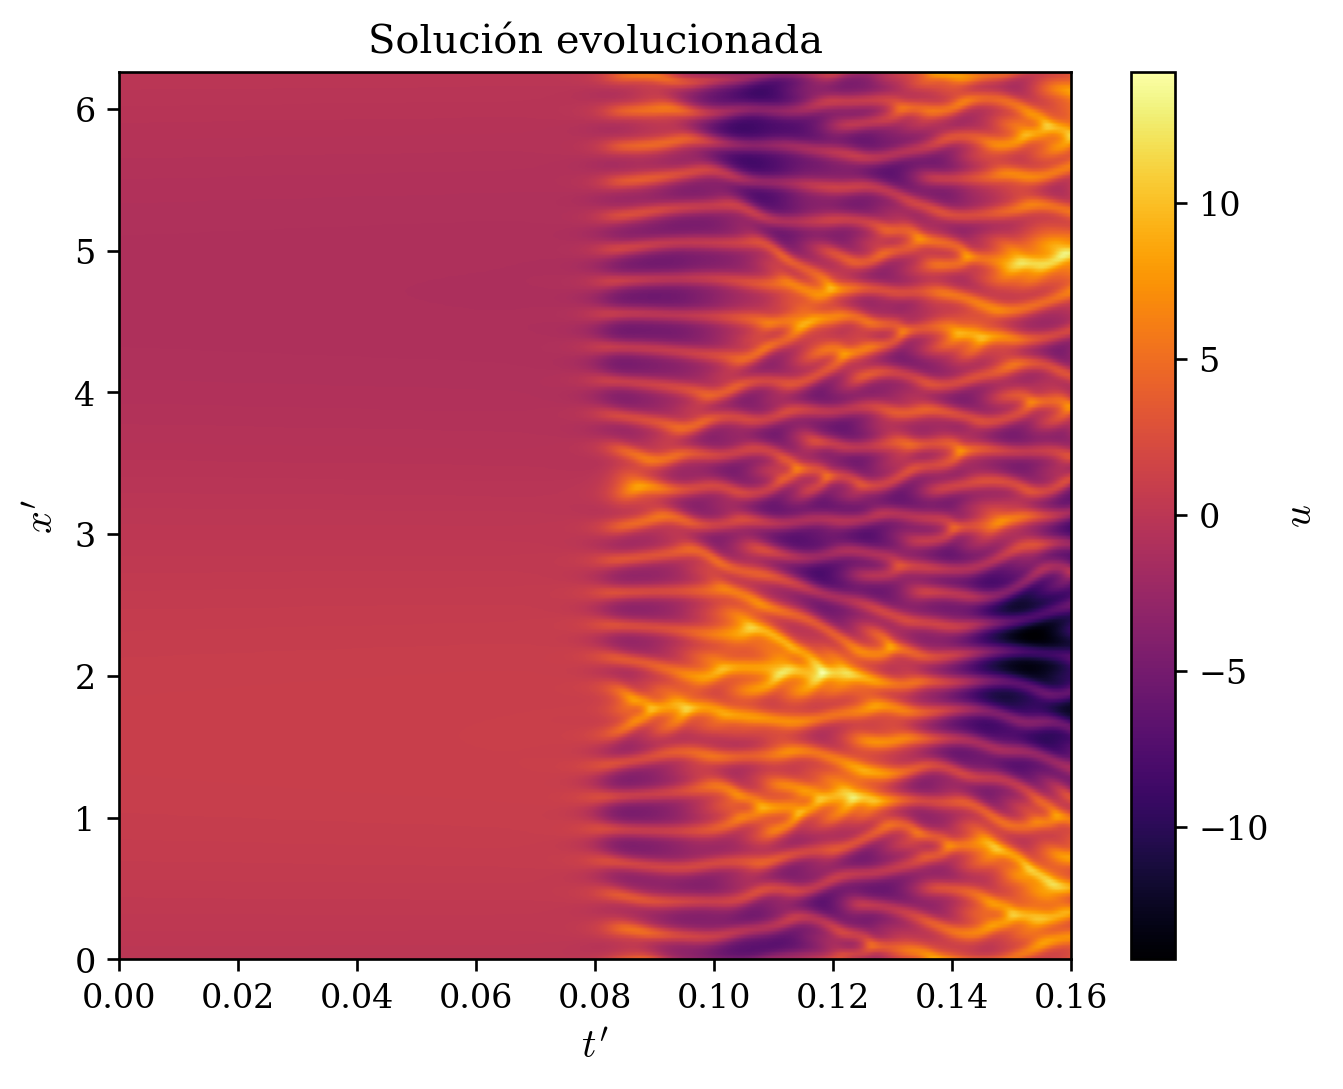

In [7]:
# L = 40, u0 = sin(x), nx = 256
plt.close("all")
%matplotlib inline
dt = 1e-6
tf = 160_000*dt
L = 40
x_vals, t_vals, u = kuramoto_sivashinsky_pseudoespectral(
    # lambda x: gaussian(x, np.pi, np.pi/3),
    lambda x: np.sin(x),
    L=L,
    tf=tf,
    nx=256,
    dt=dt,
)

u_plot = u - np.mean(u, axis=0, keepdims=True)

plt.figure()
plt.title("Solución evolucionada")
# xx_vals, tt_vals = np.meshgrid(x_vals, t_vals, indexing='ij')
# plt.pcolormesh(tt_vals, xx_vals, u_plot, cmap="plasma")
plt.imshow(u_plot, cmap="inferno", origin="lower", extent=[t_vals[0], t_vals[-1], x_vals[0], x_vals[-1]], aspect="auto")
plt.xlabel("$t^\prime$")
plt.ylabel("$x^\prime$")
plt.colorbar(label="$u$")
plt.show()

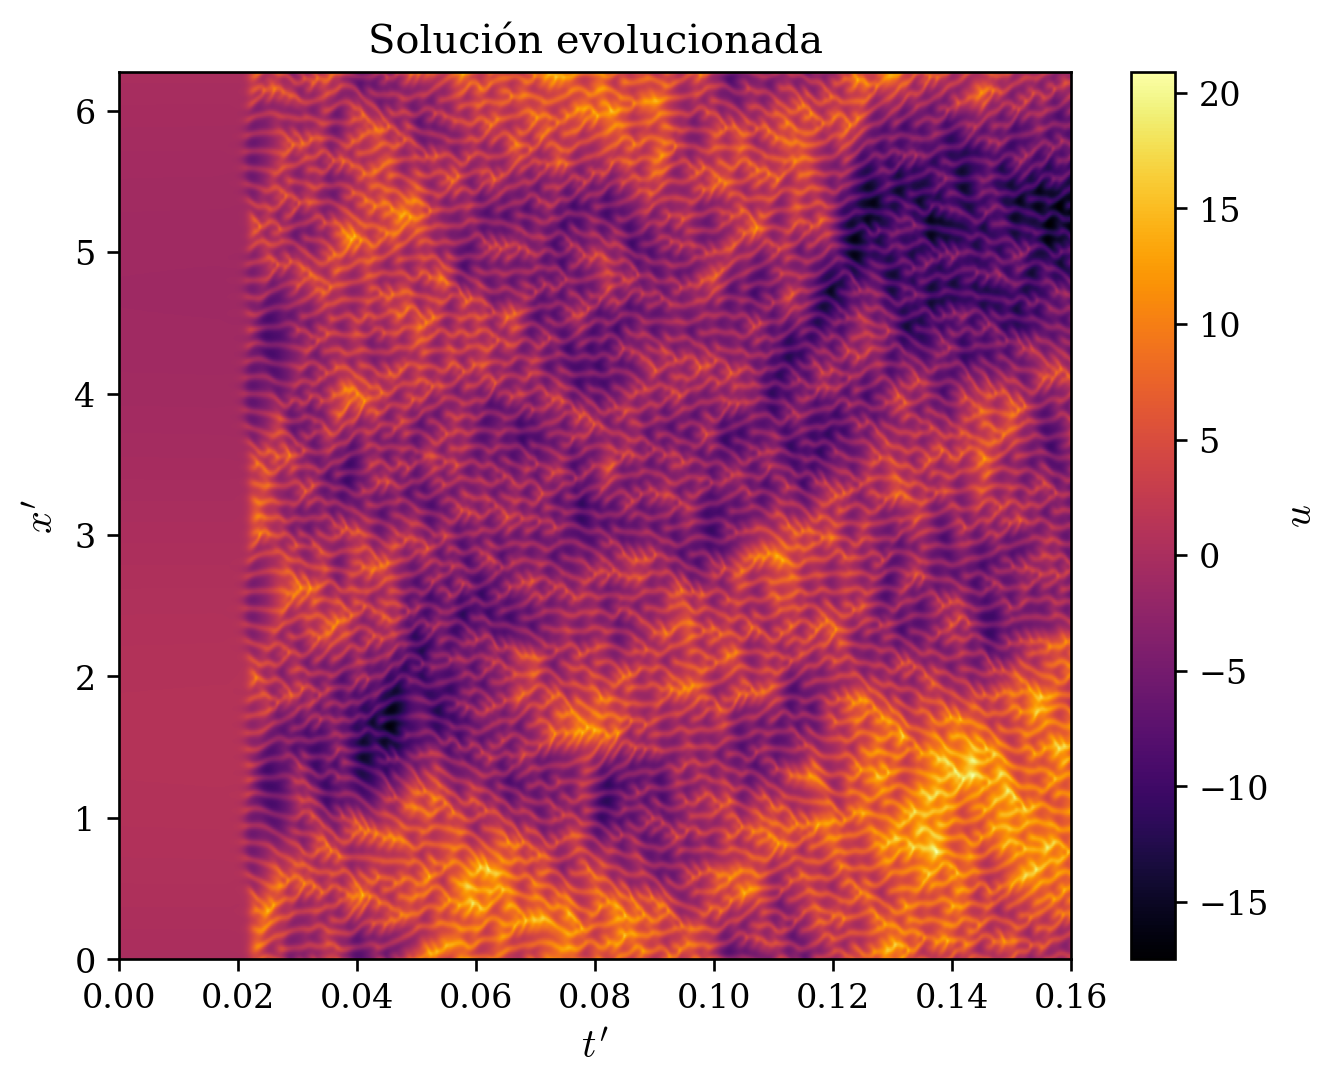

In [6]:
# L = 80, u0 = sin(x), nx = 512
plt.close("all")
%matplotlib inline
dt = 1e-6
tf = 160_000*dt
L = 80
x_vals, t_vals, u = kuramoto_sivashinsky_pseudoespectral(
    # lambda x: gaussian(x, np.pi, np.pi/3),
    lambda x: np.sin(x),
    L=L,
    tf=tf,
    nx=512,
    dt=dt,
)

u_plot = u - np.mean(u, axis=0, keepdims=True)

plt.figure()
plt.title("Solución evolucionada")
# xx_vals, tt_vals = np.meshgrid(x_vals, t_vals, indexing='ij')
# plt.pcolormesh(tt_vals, xx_vals, u_plot, cmap="viridis")
plt.imshow(u_plot, cmap="inferno", origin="lower", extent=[t_vals[0], t_vals[-1], x_vals[0], x_vals[-1]], aspect="auto")
plt.xlabel("$t^\prime$")
plt.ylabel("$x^\prime$")
plt.colorbar(label="$u$")
plt.show()

Pasos de Pseudo-Espectral:   0%|          | 0/160000 [00:00<?, ?it/s]

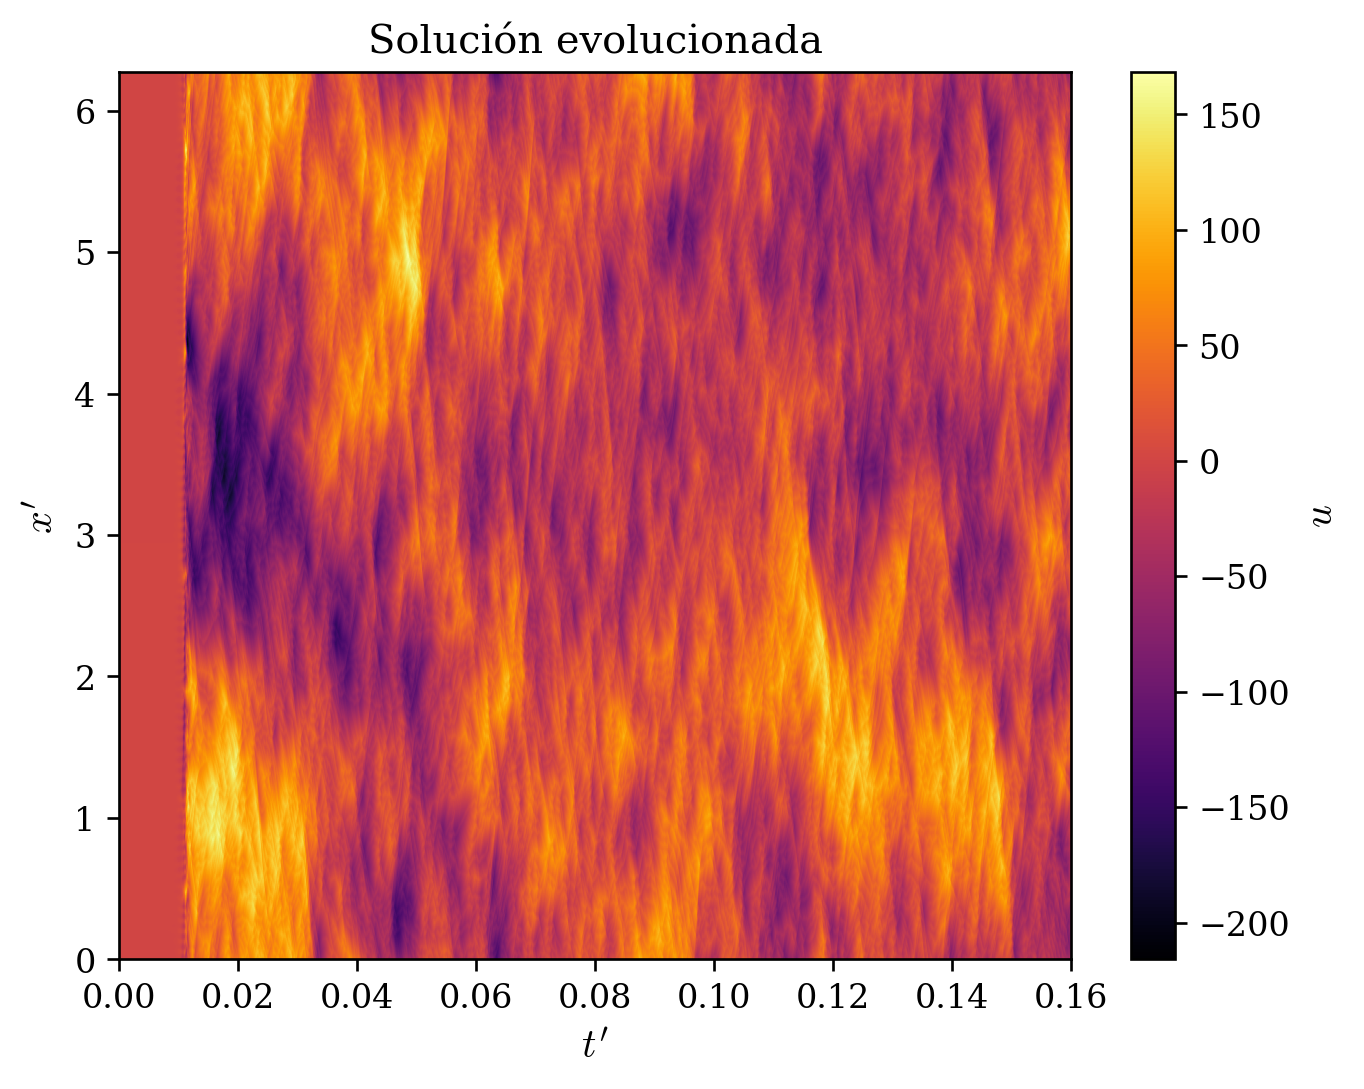

In [8]:
# L = 120, u0 = sin(x), nx = 512
plt.close("all")
%matplotlib inline
dt = 1e-6
tf = 160_000*dt
L = 120
x_vals, t_vals, u = kuramoto_sivashinsky_pseudoespectral(
    # lambda x: gaussian(x, np.pi, np.pi/3),
    lambda x: np.sin(x),
    L=L,
    tf=tf,
    nx=512,
    dt=dt,
)

u_plot = u - np.mean(u, axis=0, keepdims=True)

plt.figure()
plt.title("Solución evolucionada")
# xx_vals, tt_vals = np.meshgrid(x_vals, t_vals, indexing='ij')
# plt.pcolormesh(tt_vals, xx_vals, u_plot, cmap="viridis")
plt.imshow(u_plot, cmap="inferno", origin="lower", extent=[t_vals[0], t_vals[-1], x_vals[0], x_vals[-1]], aspect="auto")
plt.xlabel("$t^\prime$")
plt.ylabel("$x^\prime$")
plt.colorbar(label="$u$")
plt.show()

Al aumentar el valor de $L$ (y $n_x$) podemos observar cómo aparecen estructuras cada vez más complejas y de escalas más pequeñas, consecuencia de la aparición de modos más altos. En particular, en $L = 80, n_x = 512$ logramos resolver las estructuras más pequeñas permitiendo ver un patrón fractal. Por su parte, en $L = 120$ al mantener $n_x = 512$ (no lo aumentamos por limitaciones en memoria) notamos que no se resuelven las estructuras más pequeñas.

Notando las propiedades multiescala de las soluciones resulta claro que se necesitan muchos modos que capturen la dinámica en estas soluciones. En particular en los casos más caoticos no parece posible describir la complejidad del sistema con unos pocos modos espaciales.

### d)

En las siguientes celdas se calcula la función de estructura $S_2(l)$ y el espectro de potencia $E(k)$ para la solución.

Para calcular $E(k)$ a partir de $u(x, t)$ partimos de la expresión:
$$E(k) = \lim_{T\to\infty} \frac{1}{T} \int_0^T|\mathcal{F}(u)|^2 \mathrm{d}t$$
dónde discretizando en $t$ queda:
$$E(k) = \langle|\mathcal{F}(u)|^2 \rangle_t.$$

Por otro lado, para calcular $S_2(l)$ calculamos primero $S_2(l, t)$ y luego promediamos en $t$.

Nota de implementación:
Cómo calcular $S_2(l, t)$ a partir de $u(x, t)$ es computacionalmente costoso, se optó por calcular solo $S_2(l, t_i)$ para tiempos $t_i$ elegidos al azar. Dado que luego se promedia en $t$, esto no afecta la precisión de los resultados en tanto el número de muestras sea suficientemente grande. En particular, se eligieron 10.000 muestras de $t$ para el cálculo de estos resultados.

In [3]:
# Funciones para calcular la función de estructura de u
@njit
def media_compatible_con_numba(a, axis):
    """Calcula el promedio de un array `a` de Numpy a lo largo del eje `axis` de \
manera compatible con Numba.
    """
    return np.sum(a, axis=axis) / a.shape[axis]

@njit(parallel=True)
def diferencia_cuadratica_shifteada(u, l_vals):
    s_2 = np.zeros_like(u)
    for i in prange(1, l_vals.size):  # start from 1
        delta_u_l = np.concatenate((u[-i:, :], u[:-i, :]), axis=0) - u
        s_2[i] = media_compatible_con_numba(delta_u_l**2, axis=0)
    return media_compatible_con_numba(s_2, axis=1)

def calcular_estructura_numba(
    u: ArrayLike, x_vals: ArrayLike, sample_size: int, seed: int = 42,
) -> ArrayLike:
    """Calcula la estructura de la función `u` en el espacio `x_vals`. \
Para ello, calcula la función de correlación espacial `S_2` de la función `u`, \
para `sample_size` tiempos muestreados, realizando los promedios con numba.
    """
    l_vals = np.linspace(0, np.max(x_vals) - np.min(x_vals), x_vals.size)
    s_2 = np.zeros_like(x_vals)
    rng = np.random.default_rng(seed)
    u_muestra = rng.choice(u, size=sample_size, replace=False, axis=1)
    s_2 = diferencia_cuadratica_shifteada(u_muestra, l_vals)
    return s_2, l_vals

Pasos de Pseudo-Espectral:   0%|          | 0/160000 [00:00<?, ?it/s]

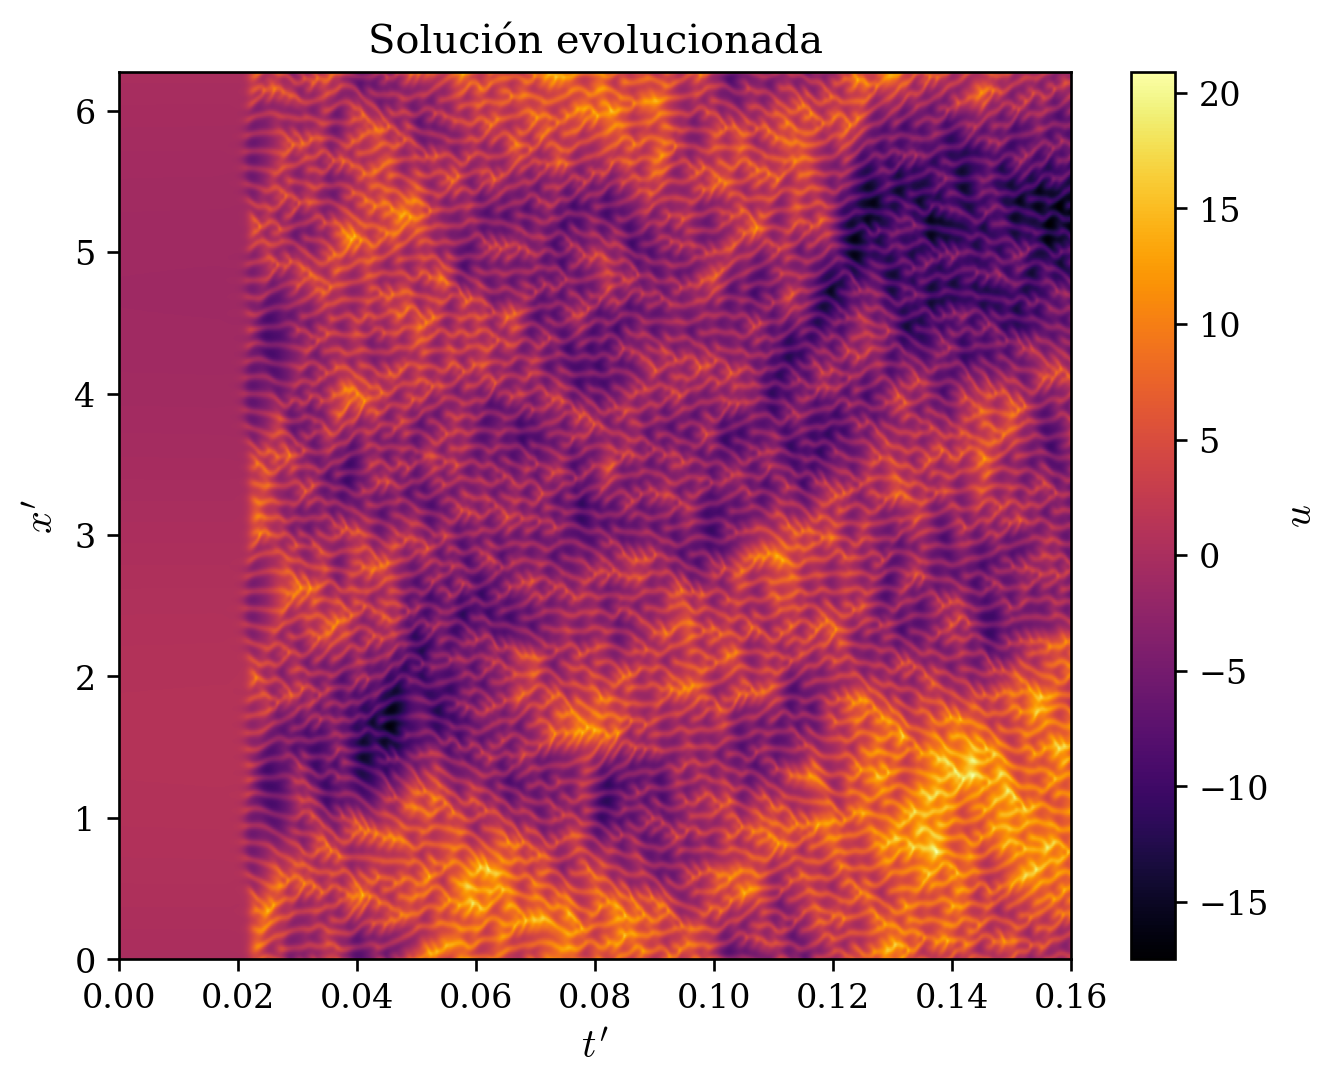

In [4]:
# Integramos una solución en el régimen caótico para calcularle E y S_2
dt = 1e-6
tf = 160_000*dt
L = 80
x_vals, t_vals, u = kuramoto_sivashinsky_pseudoespectral(
#    lambda x: gaussian(x, np.pi, np.pi/3),
    lambda x: np.sin(x),
    L=L,
    tf=tf,
    nx=512,
    dt=dt,
)
u_plot = u - np.mean(u, axis=0, keepdims=True)

plt.figure()
plt.title("Solución evolucionada")
# xx_vals, tt_vals = np.meshgrid(x_vals, t_vals, indexing='ij')
# plt.pcolormesh(tt_vals, xx_vals, u_plot, cmap="viridis")
plt.imshow(u_plot, cmap="inferno", origin="lower", extent=[t_vals[0], t_vals[-1], x_vals[0], x_vals[-1]], aspect="auto")
plt.xlabel("$t^\prime$")
plt.ylabel("$x^\prime$")
plt.colorbar(label="$u$")
plt.show()

In [5]:
# Calculamos E y S_2 en la región de la solución que presenta estructuras
t_min_dinamica = 0.02
filtro_t = t_vals > t_min_dinamica
u_dinamica = u[:, filtro_t]

estructura, l_vals = calcular_estructura_numba(u_dinamica, x_vals, sample_size=10_000)

k_vals = np.fft.rfftfreq(x_vals.size, d=(x_vals[1] - x_vals[0])) * 2 * np.pi
u_hat = np.fft.rfft(u_dinamica, axis=0)
espectro_potencia = np.mean(np.abs(u_hat)**2, axis=1)[:2*(k_vals.size // 3)]
k_vals = k_vals[:2*(k_vals.size // 3)]

Graficando $E(k)$ esperamos encontrar un rango disipativo que debería seguir una ley de potencias $E \sim k^\alpha$ a lo largo de al menos una decada (siendo generosos). Así, si el sistema es libre de escala este exponente debería estar entre $-3$ y $-1$ (de manera que $n = -\alpha \in (1, 3)$).

Dicho eso, se realizó un ajuste considerando la región (aparentemente) lineal más extensa del espectro.

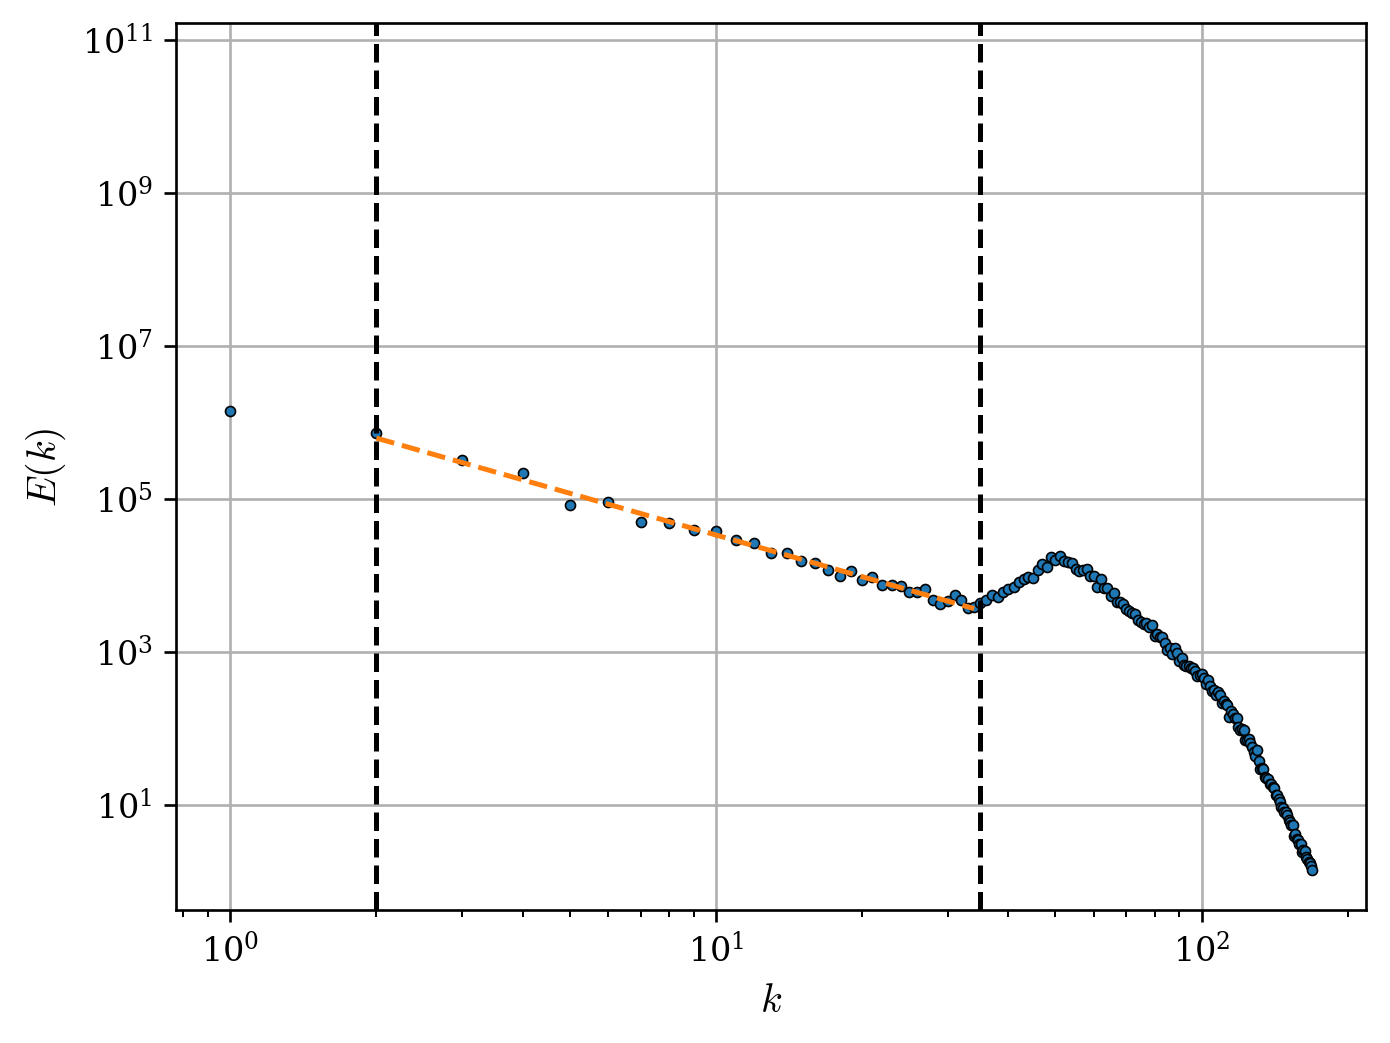

In [15]:
# E(k) ~ k^α
# idx_min = 110
# idx_max = 169
# idx_min = 60
# idx_max = 110
idx_min = 2
idx_max = 35
k_fit = k_vals[idx_min:idx_max]
e_fit = espectro_potencia[idx_min:idx_max]
popt, pcov = np.polyfit(np.log(k_fit), np.log(e_fit), 1, cov=True, )
perr = np.sqrt(np.diag(pcov))
alpha_val = popt[0]
alpha_err = perr[0]
plt.plot(k_vals, espectro_potencia, ".", mec="k", mew=0.5)
plt.plot(k_fit, np.exp(popt[1])*k_fit**popt[0], "--")
plt.axvline(k_vals[idx_min], color="k", linestyle="--")
plt.axvline(k_vals[idx_max], color="k", linestyle="--")
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$k$")
plt.ylabel("$E(k)$")
plt.show()

Repitiendo este análisis para $S_2(l)$ ajustamos por una ley de potencias $S_2 \sim l^\beta$ en la región asociada a los valores de $k$ ajustados arriba usando que $k \sim l^{-1}$.

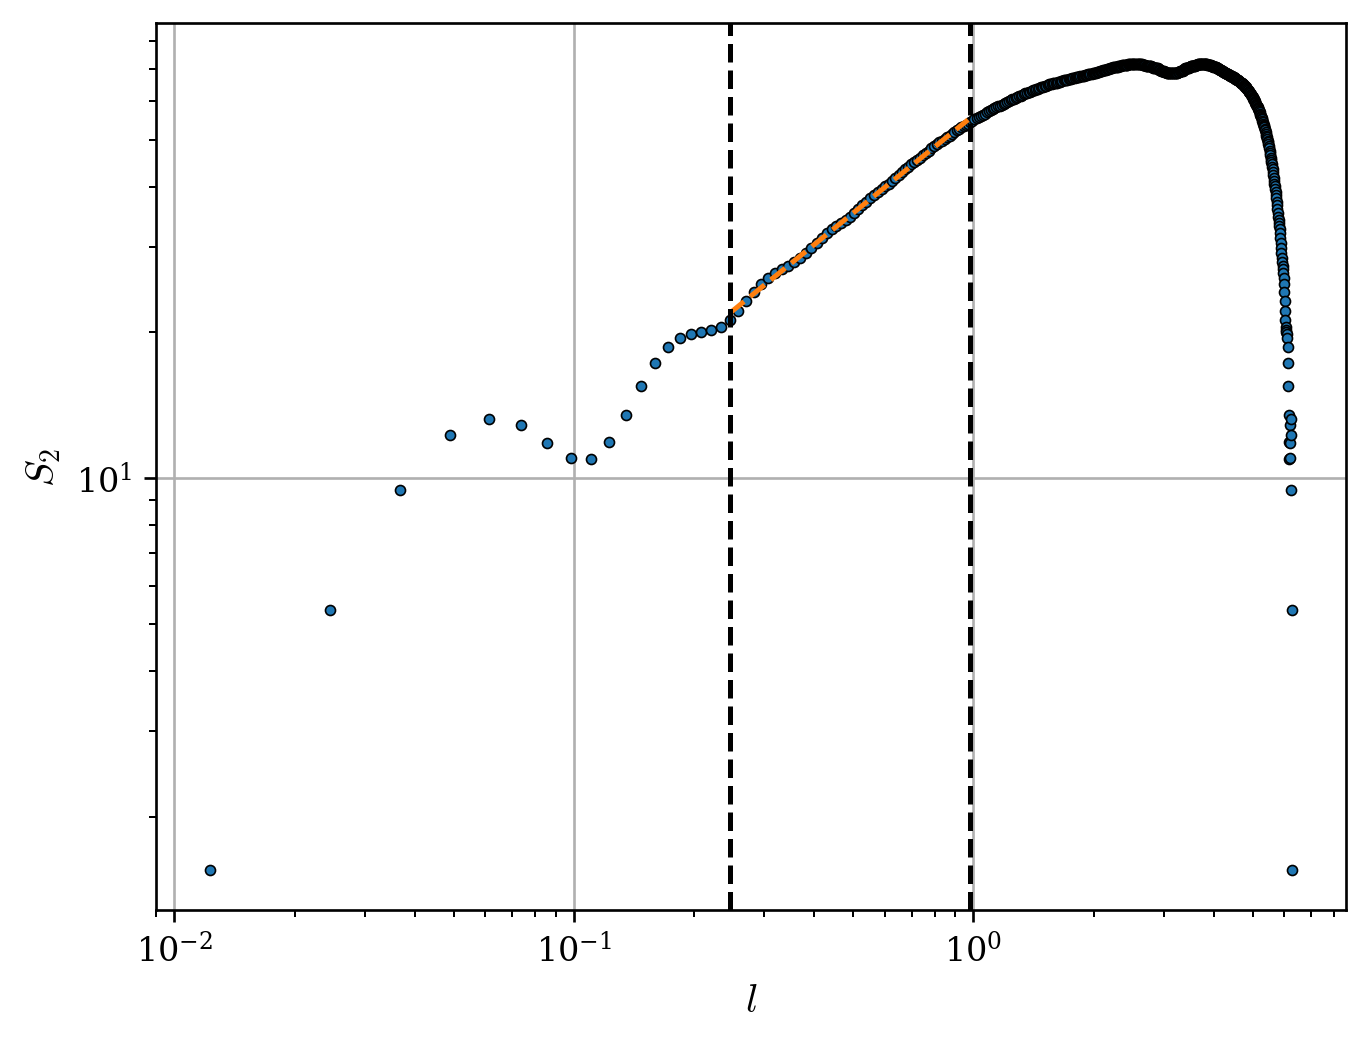

In [16]:
# S_2(l) ~ l^β
idx_min = 20
idx_max = 80
l_fit = l_vals[idx_min:idx_max]
s_fit = estructura[idx_min:idx_max]
popt, pcov = np.polyfit(np.log(l_fit), np.log(s_fit), 1, cov=True, )
perr = np.sqrt(np.diag(pcov))
beta_val = popt[0]
beta_err = perr[0]
plt.plot(l_vals, estructura, ".", mec="k", mew=0.5)
plt.plot(l_fit, np.exp(popt[1])*l_fit**popt[0], "--")
plt.axvline(l_vals[idx_min], color="k", linestyle="--")
plt.axvline(l_vals[idx_max], color="k", linestyle="--")
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$l$")
plt.ylabel("$S_2$")
# plt.xlim(0.1, 5)
plt.show()

Para comparar estos resultados con los predichos por la teoría, queremos corroborar la relación de los exponentes ajustados con $n$ según:
$$\alpha = -n \Rightarrow n_\alpha = -\alpha$$
$$\beta = n-1 \Rightarrow n_\beta = \beta + 1.$$
Así, de los ajustes realizados obtenemos:

In [19]:
print(f"n_α = {-alpha_val:.2f} ± {alpha_err:.1g}")
print(f"n_β = {beta_val + 1:.3f} ± {beta_err:.1g}")

n_α = 1.81 ± 0.03
n_β = 1.669 ± 0.003


Si bien ambos valores pertenecen al intervalo $(1, 3)$ como se espera para sistemas libres de escala, en contradicción con la teoría estos resultados presentan diferencias significativas entre sí.

Dicho eso, los valores hayados dependen de los intervalos elegidos y podrían diferir ajustando en otras regiones.